<a href="https://colab.research.google.com/github/GwenTsang/Papyri/blob/main/corpus_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# La chasse au papyrus

# 1) Collecte des URL

 A partir de la liste des papyri à étudier, générez la liste des url à crawler. Pour cela parcourez le site pour comprendre la structure des url donnant accès à un papyrus.

# **Scraping**

La fonction `scrap_papyrus()` retourne un JSON contenant les informations suivantes sur le papyrus:</br>

✅ Language</br>
✅ Content</br>
✅ Date</br>
✅ Provenance</br>
✅ Material</br>
✅ Archive</br>
✅ Collections</br>
✅ Publications</br>
✅ Le texte grec formaté</br>
✅ La liste des noms de personnes</br>
✅ La liste des noms de lieux</br>
✅ La liste des irrégularités textuelles</br>

Plus précisément :
```python
            item_data = {
                "Language": None,
                "Content": None,
                "Date": None,
                "Provenance": None,
                "Material": None,
                "Archive": [],
                "Collections": [],
                "Publications": [],
                "GreekText": None,
                "People": [],
                "Places": [],
                "Irregularities": []
            }
```



In [ ]:
!wget https://raw.githubusercontent.com/Dinarque/INALCO_Techniques_web_en_python_2025/refs/heads/main/TP/papyrus_corpus.csv -q

### **Pipeline de nettoyage**

[<img src="https://img.icons8.com/material-outlined/24/000000/download--v1.png"/> **Téléchargez le fichier py pour faire le scrapping**](https://raw.githubusercontent.com/GwenTsang/Papyri/refs/heads/main/scrapping/scrapapyrus.py)


[<img src="https://img.icons8.com/material-outlined/24/000000/download--v1.png"/> **Téléchargez le JSON contenant les métadonnées de 10 pages scrappées**](https://github.com/GwenTsang/Papyri/blob/main/data/trismegistos_data_papyrus_1-10-full.json)


# II) Analyse du dataset



Dans cette partie, nous allons utiliser les librairies de datascience pour visualiser, analyser et enrichir le corpus que nous avons scrapé

#### **Détails sur le nettoyage**


Dans le code python qui suit, on utilise une regex pour enlever :
- les chiffres arabes (qui indiquaient vraissemblablement les numéros des lignes),
- les " | gap | " qui indiquent des lignes perdues,
- les caractères spéciaux "†" et "⳨".


```python

df["Full Text"] = (df["Full Text"]
    .str.replace(r"\d+", "", regex=True)
    .str.replace(r"\| gap \|", "", regex=True)
    .str.replace(r"[†⳨]", "", regex=True)
)

```

```python

uncertain_chars = re.findall(r'\[.*?\]|\(.*?\)', text)

```

Notons que les parenthèses correspondent à du texte perdu et reconstruit tandis que les parenthèses correspondent à du texte qui a été abrégé.
</br>

Si on souhaitait distinguer l'un et l'autre, on peut utiliser :
```python

matches = re.compile(r"\[(.*?)\]|\((.*?)\)").findall(text)

```
qui permet une distinction entre les strings qui se trouvaient entre parenthèses et celles qui se trouvaient entre crochets. Mais ici on **supprime** toutes les parenthèses et tous les crochets.
On peut se référer aux [conventions de Leiden](https://en.wikipedia.org/wiki/Leiden_Conventions) pour découvrir le sens de chaque symbole.

Voici la signification de certains codes en papyrologie :

 - Les petits points en dessous de certaines lettres indiquent que la lettre est défformée ou difficilement lisible,

On les retire. Mais il semble que ça diminue un peu (bizarement) les performances du NER

In [ ]:
import pandas as pd
import numpy as np
import re
import ast
import unicodedata

class PapyrusCleaner:
    def __init__(self, dataframe):
        self.df = dataframe.copy()
        # Regex pour le grec ancien et étendu
        # \u0370-\u03FF : Grec et Copte
        # \u1F00-\u1FFF : Grec étendu (polytonique)
        # \u0300-\u036F : Diacritiques combinants
        self.greek_regex = r"[\u0370-\u03FF\u1F00-\u1FFF\u0300-\u036F]"

    def _normalize_greek(self, text):
        """
        Normalisation standard : minuscule, suppression des diacritiques,
        et normalisation du sigma final.
        """
        if not isinstance(text, str):
            return ""
        text = text.lower()
        text = unicodedata.normalize("NFD", text)
        text = "".join(c for c in text if unicodedata.category(c) != "Mn")
        text = unicodedata.normalize("NFC", text)
        text = text.replace("ς", "σ")
        return text.strip()

    def _parse_list_column(self, text):
        """
        Transforme les chaînes str en listes python.
        Gère les listes ['a', 'b'] ET les dictionnaires {'lieu': 'id'}.
        """
        try:
            # ast.literal_eval transforme la chaîne en objet Python (list ou dict)
            val = ast.literal_eval(str(text))

            raw_items = []

            # CAS 1 : C'est une liste (format de 'People List')
            if isinstance(val, list):
                raw_items = val

            # CAS 2 : C'est un dictionnaire (format de 'Places List')
            elif isinstance(val, dict):
                # On récupère les clés car c'est là que sont les noms grecs
                raw_items = list(val.keys())

            else:
                return []

            # On nettoie chaque élément trouvé
            return [self._normalize_greek(x) for x in raw_items if isinstance(x, str)]

        except (ValueError, SyntaxError):
            return []

    def filter_valid_rows(self):
        print("--- Filtrage des lignes invalides ---")
        initial_len = len(self.df)
        valid_text = (
            self.df["Full Text"].notna() &
            (self.df["Full Text"].astype(str).str.strip() != "") &
            ~self.df["Full Text"].astype(str).str.lower().str.contains("nan", regex=False)
        )
        has_greek = self.df["Full Text"].astype(str).str.contains(self.greek_regex, regex=True, na=False)
        self.df = self.df[valid_text & has_greek]
        print(f"Lignes supprimées : {initial_len - len(self.df)}")
        return self

    def clean_full_text_content(self):
        print("Nettoyage du corps du texte (Full Text)")
        def cleaner(text):
            if not isinstance(text, str): return ""
            text = re.sub(r"\d+", "", text)
            text = re.sub(r"\| gap \|", "", text)
            text = re.sub(r"[†⳨]", "", text)
            text = re.sub(r"\s+", " ", text).strip()
            return text
        self.df["Full Text Cleaned"] = self.df["Full Text"].apply(cleaner)
        self.df["Full Text Normalized"] = self.df["Full Text Cleaned"].apply(self._normalize_greek)
        return self

    def process_metadata_lists(self):
        print("Traitement des métadonnées (People & Places)")
        cols_to_fix = ["People List", "Places List"]
        for col in cols_to_fix:
            if col in self.df.columns:
                # Applique la nouvelle logique qui accepte listes ET dicts
                self.df[f"{col} Processed"] = self.df[col].apply(self._parse_list_column)
        return self

    def format_dates(self):
        print("--- Formatage des dates ---")
        def clean_date(text):
            if not isinstance(text, str): return None
            parts = text.split(":")[-1].strip()
            match = re.search(r'(AD|BC)\s*(\d+)(?:\s*-\s*(\d+))?', parts)
            if match:
                era = match.group(1)
                start = match.group(2)
                end = match.group(3)
                if end: return f"{era} {start} - {end}"
                return f"{era} {start}"
            return parts
        self.df["Date Cleaned"] = self.df["Date"].apply(clean_date)
        return self

    def compute_uncertainty(self):
        print("--- Calcul de l'incertitude ---")
        def calculate_ratio(text):
            if not isinstance(text, str): return 0.0
            matches = re.findall(r"\[[^\]]*?\]|\([^\)]*?\)", text)
            uncertain_len = sum(len(m) - 2 for m in matches)
            total_len = len(text) - text.count('[') - text.count(']') - text.count('(') - text.count(')')
            if total_len == 0: return 0.0
            return uncertain_len / total_len
        self.df["Uncertainty Ratio"] = self.df["Full Text Cleaned"].apply(calculate_ratio)
        return self

    def clean_irregularities(self):
        print("--- Nettoyage des irrégularités textuelles ---")
        def parse_irregularities(text):
            try:
                items = ast.literal_eval(str(text))
                if not isinstance(items, list): return []
            except: return []
            cleaned_items = []
            for item in items:
                if isinstance(item, str) and ': read ' in item:
                    parts = item.split(': read ')
                    if len(parts) == 2:
                        cleaned_items.append(f"{self._normalize_greek(parts[0])} : read {self._normalize_greek(parts[1])}")
            return cleaned_items
        self.df["Irregularities Processed"] = self.df["Text Irregularities"].apply(parse_irregularities)
        return self

    def get_dataframe(self):
        return self.df

# Rechargement du fichier brut
df_raw = pd.read_csv("/content/papyrus_corpus.csv")

# Pipeline
pipeline = PapyrusCleaner(df_raw)
df_clean = (pipeline
            .filter_valid_rows()
            .clean_full_text_content()
            .format_dates()
            .process_metadata_lists()
            .compute_uncertainty()
            .clean_irregularities()
            .get_dataframe()
           )

# Sauvegarde
df_clean.to_csv("/content/papyrus_corpus_cleaned.csv", index=False)
print("Pipeline terminée. Places List devrait maintenant être rempli.")

# Vérification immédiate
print("\n--- Vérification des 5 premiers lieux trouvés ---")
print(df_clean["Places List Processed"].head().to_list())

--- Filtrage des lignes invalides ---
Lignes supprimées : 123
Nettoyage du corps du texte (Full Text)
--- Formatage des dates ---
Traitement des métadonnées (People & Places)
--- Calcul de l'incertitude ---
--- Nettoyage des irrégularités textuelles ---
Pipeline terminé avec succès. Places List devrait maintenant être rempli.

--- Vérification des 5 premiers lieux trouvés ---
[[], [], ['του αγιου τοπου απα μιχαηλ', 'τη[σ ανταιου]'], ['εισ κυνων'], ['απο κερκη', 'απο κωμα']]


Dans ce qui suit, on utilisera deux DataFrames distincts :


In [ ]:
df_raw = pd.read_csv("papyrus_corpus.csv")
df_clean = pd.read_csv("papyrus_corpus_cleaned.csv")

* Afficher les 4 premières lignes

In [ ]:
df_clean.head(4)

,ID,Authors / works,Book form,Content (beta!),Culture & genre,Date,Full Text,Language/script,Material,Note,...,Reuse type,Ro,Text Irregularities,Full Text Cleaned,Full Text Normalized,Date Cleaned,People List Processed,Places List Processed,Uncertainty Ratio,Irregularities Processed
0,TM 19028,NaN,NaN,Contract: sale,NaN,AD 490 - 565,1 [--------------------] [.....] [Διοσκ]ό̣ρο...,Greek,NaN,NaN,...,NaN,NaN,['καθ’: read κατʼ'],[--------------------] [.....] [Διοσκ]ό̣ρου̣ ε...,[--------------------] [.....] [διοσκ]ορου ε[-...,AD 490 - 565,"['1διοσκορου', 'subscribe to export the table']",[],0.495394,['καθ’ : read κατʼ']
1,TM 19001,NaN,NaN,Receipt,NaN,AD 507 Mar 21?AD 492 Mar 21?,1 [⳨] δ̣[έ]δ̣[ω]κ̣[εν] Διόσκορ[ος] [Ψ]ιμανω...,Greek,NaN,NaN,...,NaN,NaN,['σεμημείωμαι: read σεσημείωμαι'],[] δ̣[έ]δ̣[ω]κ̣[εν] Διόσκορ[ος] [Ψ]ιμανωβετ δ(...,[] δ[ε]δ[ω]κ[εν] διοσκορ[οσ] [ψ]ιμανωβετ δ(ια)...,AD 507,"['1διοσκοροσ', 'ψιμανωβετ', 'subscribe to expo...",[],0.322835,['σεμημειωμαι : read σεσημειωμαι']
2,TM 45294,NaN,NaN,Receipt,NaN,6th century AD: AD 500 - 599,1 † τὸ δίκα[ι]ον τοῦ ἁγίου τόπου ἄπα Μ̣...,Greek,NaN,NaN,...,NaN,NaN,[],τὸ δίκα[ι]ον τοῦ ἁγίου τόπου ἄπα Μ̣ιχα̣η̣λί̣ο̣...,το δικα[ι]ον του αγιου τοπου απα μιχαηλιου [δι...,AD 500 - 599,"['1αραουτοσ', '2φοιβαμμωνι', 'τριαδελφου', '7α...","['του αγιου τοπου απα μιχαηλ', 'τη[σ ανταιου]']",0.463074,[]
3,TM 38431,NaN,NaN,List,NaN,6th century AD: AD 500 - 599,1 χμγ 2 |̣ṣṭạụṛọṣ|̣ ἀ̣ρ̣ι̣θ̣μηθέντα ε...,Greek,NaN,NaN,...,NaN,NaN,['νταρίου: read ν<ο>ταρίου'],χμγ |̣ṣṭạụṛọṣ|̣ ἀ̣ρ̣ι̣θ̣μηθέντα εἰς τὸν...,χμγ |stauros| αριθμηθεντα εισ τον λογον αμμωνι...,AD 500 - 599,"['3αμμωνιανοσ', 'διονυσοδωρου', '4παιοσ', 'θεω...",['εισ κυνων'],0.299685,['νταριου : read ν<ο>ταριου']


* **Combien de textes n'ont pas été capturés pendant le scraping ?**


In [ ]:
# Compter le nombre de cellules contenant "nan" dans la colonne 'Full Text'

# Pour compter les vraies valeurs manquantes (NaN) :
count_nan = df_raw["Full Text"].isna().sum()

print(f"Nombre de cellules manquantes dans la colonne 'Full Text': {count_nan}")
print(f"Si on les enlève, il restera {len(df_raw) - count_nan} papyri clean")

Nombre de cellules manquantes dans la colonne 'Full Text': 120
Si on les enlève, il restera 459 papyri clean



* **Trier la collection selon l'ID (ordre croissant)**

In [ ]:
import pandas as pd

# Sorting the DataFrame
df_clean = df_clean.sort_values(
    by="ID",
    key=lambda x: x.str.replace("TM ", "", regex=False).astype(int)
)

# 5) Etude de corpus : genre, lieu et date



**Quelles sont les différents genre de texte que l'on a collecté ?**

In [ ]:
genres_uniques = df_clean["Content (beta!)"].unique()
print(genres_uniques)

['Petition' 'Contract: loan' 'Receipt: taxes' 'Contract: lease'
 'Contract: surety' 'Other: fragment' 'Receipt' 'Contract'
 'Letter: official' 'Bond' 'Judicial: edict'
 'PetitionSee also TM Letters TOP SS6 (1formula).'
 'LetterSee also TM Letters TOP SS6 (1formula).' 'Contract: sale'
 'PetitionSee also TM Letters TOP SS6 (3formulae).'
 'Letter: officialSee also TM Letters TOP SS6 (2formulae).'
 'Receipt: debt' 'Contract: marriage / divorce' 'Contract: testament'
 'Contract: division' 'List' 'Receipt: order' 'Administration: register'
 'Account' 'Account: private' 'Contract: donation' 'Judicial: protocol'
 'Record' 'Letter' 'End of a ekmarturion'
 'LetterSee also TM Letters TOP SS6 (2formulae).'
 'PetitionSee also TM Letters TOP SS6 (2formulae).' 'Receipt: payment'
 'Letter: payment order'
 'Receipt: orderSee also TM Letters TOP SS6 (1formula).'
 'LetterSee also TM Letters TOP SS6 (3formulae).'
 'report legal proceedings (inheritance dispute)'
 'Delivery of wheat and meat for the army' 

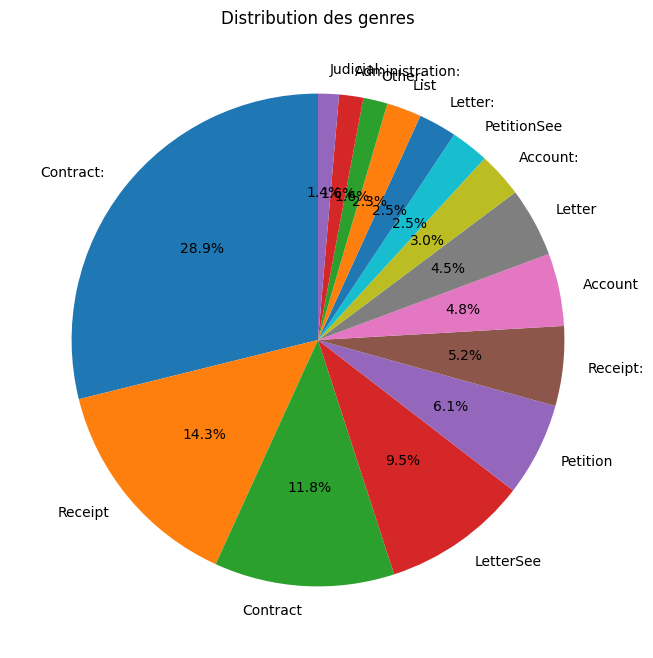

In [ ]:
import pandas as pd
from matplotlib.pyplot import subplots
from matplotlib.pyplot import show


# Enlever les valeurs NaN values et spliter en espace pour récupérer le premier mot
first_words = df_clean["Content (beta!)"].dropna().str.split().str[0]

# Compter les occurences de chaque mot
word_counts = first_words.value_counts()

# Limitation à 10 catégories (en supprimant les autres dans le calcul)
word_counts = word_counts.head(15)

# Création du pie chart
fig, ax = subplots(figsize=(10, 8))
ax.pie(word_counts.values, labels=word_counts.index, autopct='%1.1f%%', startangle=90)
ax.set_title('Distribution des genres')

# Affichage du chart
show()

* **D'où viennent les papyri ?  De même ne retenez que le nom de la ville. Faites un diagramme en barre .**

In [ ]:
# Inspecter le contenu de la colonne "Provenance" sous forme de liste

print(df_clean["Provenance"].dropna().str.split().str[0].to_list())

['Antinoopolis', 'Antinoopolis', 'Aphrodito', 'Aphrodito', 'Antinoopolis', 'Aphrodito', 'Aphrodito', 'Aphrodito', 'Aphrodito', 'Aphrodito', 'Byzantion', 'Aphrodito', 'Antaiopolis', 'Antaiopolis', 'Aphrodito', 'Aphrodito', 'Antinoopolis', 'Aphrodito', 'Aphrodito', 'Byzantion', 'Aphrodito', 'Aphrodito', 'Antinoopolis', 'Antinoopolis', 'Aphrodito', 'Aphrodito', 'Antinoopolis', 'Aphrodito', 'Aphrodito', 'Aphrodito', 'Antinoopolis', 'Aphrodito', 'Aphrodito', 'Antinoopolis', 'Aphrodito', 'Antinoopolis', 'Aphrodito', 'Aphrodito', 'Aphrodito', 'Antinoopolis', 'Antinoopolis', 'Antinoopolis', 'Antinoopolis', 'Antinoopolis', 'Aphrodito', 'Antinoopolis', 'Aphrodito', 'Aphrodito', 'Aphrodito', 'Aphrodito', 'Aphrodito', 'Aphrodito', 'Aphrodito', 'Antinoopolis', 'Antinoopolis', 'Antinoopolis', 'Antinoopolis', 'Antinoopolis', 'Aphrodito', 'Aphrodito', 'Aphrodito', 'Byzantion', 'Aphrodito', 'Aphrodito', 'Aphrodito', 'Aphrodito', 'Aphrodito', 'Aphrodito', 'Aphrodito', 'Aphrodito', 'Aphrodito', 'Aphrodit

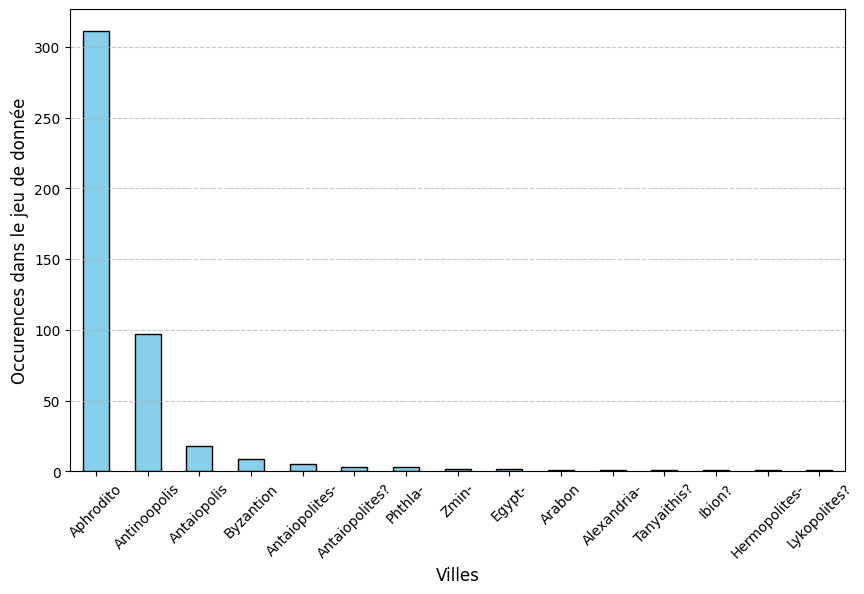

In [ ]:
import matplotlib.pyplot as plt

cities = df_clean["Provenance"].dropna().str.split().str[0]

city_counts = cities.value_counts()

plt.figure(figsize=(10, 6))
city_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.xlabel('Villes', fontsize=12)
plt.ylabel('Occurences dans le jeu de donnée', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

**Réponse** : La majorité des papyri proviennent d'Aphrodito

In [ ]:
# Inspecter le contenu de la colonne "Date"
print(df_clean["Date"].head(10).to_string(index=False))

                                      aboutAD 565?
                                    AD 566 Feb 22?
                                    AD 531 May 22?
year 26 of Iustinianus: AD 551 Aug 30 - 552 Aug 28
 year 5 of Iustinus II: AD 569 Aug 29 - 570 Aug 28
                                      AD 524 Oct 6
                                      AD 518 - 527
epagomenal days: AD 538 Aug 24 - 28Mesore Epago...
year 13 of Iustinianus ?: AD 538 Aug 29 - 539 A...
 year 9 of Iustinianus: AD 534 Aug 29 - 535 Aug 29




* **Formattez les dates sous le format d'une date simple AD xxx ou d'un intervalle AD xxx - xxx**




En python, `range` ne définit pas un intervalle continu, mais une suite discrète de valeurs entières.

Mais il faut obtenir un graphique qui “semble continu". Pour cela, on utilise `sns.kdeplot` qui permet de donner une ***estimation lisse*** de la distribution.

In [ ]:
import seaborn as sns
import re

def extract_years(date_str: str):
    """Extraire les années sous forme de plage, en traitant à la fois les dates après et avant J.-C."""
    match_range_ad = re.search(r'AD (\d+)\s*-\s*(\d+)', date_str) # AC = After Christ, après l'an 0
    match_single_ad = re.search(r'AD (\d+)', date_str)
    match_range_bc = re.search(r'BC (\d+)\s*-\s*(\d+)', date_str) # BC = Before Christ, avant l'an 0
    match_single_bc = re.search(r'BC (\d+)', date_str)

    if match_range_ad:
        return range(int(match_range_ad.group(1)), int(match_range_ad.group(2)) + 1)
    elif match_single_ad:
        year = int(match_single_ad.group(1))
        return range(year, year + 1)
    elif match_range_bc:
        return range(-int(match_range_bc.group(1)), -int(match_range_bc.group(2)) - 1, -1)
    elif match_single_bc:
        year = -int(match_single_bc.group(1))
        return range(year, year + 1)

    return


def cleaned_date(date_text: str) -> str:
    """Formattage des dates"""
    match = re.search(r'(AD|BC)\s*(\d+)(?:\s*[A-Za-z]+\s*\d*)?\s*-\s*(\d+)', date_text)
    if match:
        era, start_year, end_year = match.groups()
        return f"{era} {start_year} - {end_year}"

    match_single = re.search(r'(AD|BC)\s*(\d+)', date_text)
    if match_single:
        era, year = match_single.groups()
        return f"{era} {year}"

    return date_text

def extract_date(text: str) -> str:
    """Extract the date information from the text."""
    return text.split(":")[-1].strip()

def date_analysis(df: pd.DataFrame):
    """Analyser les dates et afficher un graphique de densité des papyrus au fil du temps."""
    df['Date'] = df['Date'].apply(extract_date).apply(cleaned_date)
    years = []
    for date in df['Date'].dropna():
        year_range = extract_years(date)
        if year_range:
            years.extend(year_range)

    # Générer le graphique de densité
    plt.figure(figsize=(10, 5))
    # Ici un appel à un kernel density estimator qui permet un "lissage"
    sns.kdeplot(years, fill=True)
    plt.title("Density of Papyrus per Years")
    plt.xlabel("Years")
    plt.ylabel("Density")
    plt.xlim(min(years), max(years))
    plt.grid()
    plt.show()

* **Construire un diagramme représentant la densité de papyri sur chaque année du dataset. Quand il y a plusieurs dates mentionnées dans la colonne, ne prendre en compte que la première**


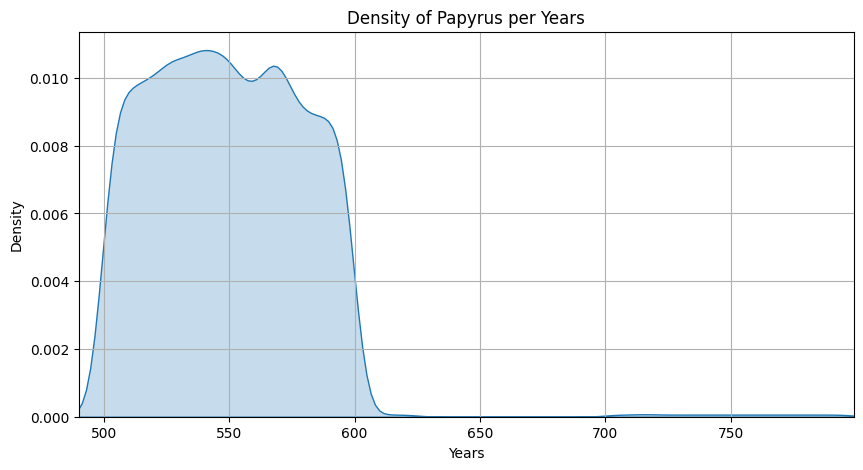

In [ ]:
date_analysis(df_clean)

Pour enlever les chiffres arabes on utilise `\d` qui correspond à un entier (0, 1, ..., 9)


**Combien y a-t de papyrus dont plus du tiers du texte est incertain ?**

In [ ]:
count_more_than_third = int((df_clean["Uncertainty Ratio"] > (1/3)).sum())
print(f"Nombre de papyrus dont plus d'un tiers est incertain : {count_more_than_third}")

Nombre de papyrus dont plus d'un tiers est incertain : 132


# 7) Identifier les noms de personnes et de lieux

* Observez le contenu des cellules de la case "people-list". Que remarquez-vous ? Réglez le(s) problème(s) de manière à ne retenir que les noms

In [ ]:
# Les noms de personnes
for i in range(18):
  print(df_clean.iloc[i, 10])

[' 13Νέπωτος', 'Ἀφθονίου', ' 14Νέπως', ' 22Ἀφθονίου', 'Subscribe to export the table']
[' 1Κωνσταντῖνος', 'Καλλινίκου', 'Διοσκόρῳ', 'Ἀπολλῶτος', ' 3Ἀπολλῶτος', 'Σενούθου', ' 6Κωνσταντῖνος', ' 7Καλλινίκου', 'Καλλινίκου', ' 10Κωνσταντίνου', 'Καλλινίκου', ' 11Καλλινίκῳ', ' 12Σενούθου', 'Ἀπολλῶτος', 'Ἀπολλῶτος', 'Subscribe to export the table']
[' 4Αὐρηλίῳ ...', ' 5Αὐρήλιοι ...', '...', 'Ἰωσηφίου', 'Subscribe to export the table']
[' 1Ἀπολλὼς', 'Διοσκώρου', ' 2Τιμοθέου', ' 4Ἰουλιανὸς', ' 5Πνιννου', 'Subscribe to export the table']
[' 3Ἀβρααμίου', ' 4Μηναδίας', ' 5Αὐρηλίων Γενναδίου', ' 6Ἀναστᾶς', ' 9Γεννάδιος', 'Ἀναστᾶ', ' 14Σερήνου', 'Subscribe to export the table']
[' 4Αὐρηλίῳ Ἀπολλῶτι', 'Διοσκόρου', ' 6Αὐρηλίου Βίκτορος', 'Ἑρμαυῶτος', 'Βίκτορος', ' 7Ψενπνούθου', 'Φοιβάμμωνος', 'Ψαίου', ' 15Βίκτορος', 'Ἑρμαυῶτος', ' 20Βίκτορος', 'Subscribe to export the table']
[' 6Αὐρήλιον Ἀπόλλωνα', ' 7Ψαίου', ' 18Αὐρήλιος', ' 19Απολλων', ' 21Αὐρήλιος Ἑρμαῶς', 'Βόττου', ' 22Ἀπόλλωνα', 'Subscribe to exp

Test d'un modèle de NER  https://huggingface.co/UGARIT/grc-ner-bert


In [ ]:
#@title Installation et test du modèle NER sur des phrases grecques simples

from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

# Chargement du modèle
tokenizer = AutoTokenizer.from_pretrained("UGARIT/grc-ner-bert")
model = AutoModelForTokenClassification.from_pretrained("UGARIT/grc-ner-bert")

# Pipeline NER
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

# Exemple
greek_text = "Ὁ Σωκράτης ἐν τῇ Ἀθήνῃ διέτριβε καὶ μετὰ τοῦ Πλάτωνος διελέγετο."
# Translation: "Socrate passe du temps à Athène et discute avec Platon."

print("Ancient Greek Text:")
print(greek_text)
print("_"*60)

# Lançement de la pipeline NER sur notre texte
entities = ner_pipeline(greek_text)

if entities:
    for entity in entities:
        print(f"Entity: {entity['word']}")
        print(f"Type: {entity['entity_group']}")
        print(f"Score: {entity['score']:.4f}")
        print(f"Position: {entity['start']}-{entity['end']}")
        print("_" * 60)
else:
    print("rien trouvé")

tokenizer_config.json:   0%|          | 0.00/407 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/449M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/449M [00:00<?, ?B/s]

Device set to use cuda:0


Ancient Greek Text:
Ὁ Σωκράτης ἐν τῇ Ἀθήνῃ διέτριβε καὶ μετὰ τοῦ Πλάτωνος διελέγετο.
____________________________________________________________
Entity: σωκρατης
Type: PER
Score: 1.0000
Position: 2-10
____________________________________________________________
Entity: αθη
Type: LOC
Score: 1.0000
Position: 17-20
____________________________________________________________
Entity: ##ν
Type: LOC
Score: 1.0000
Position: 20-21
____________________________________________________________
Entity: ##η
Type: LOC
Score: 1.0000
Position: 21-22
____________________________________________________________
Entity: πλατωνος
Type: PER
Score: 1.0000
Position: 45-53
____________________________________________________________


**Remarque sur les résultats :** vraissemblablement le modèle enlève les accents et les esprits, et qu'il met tout en minuscule. Mais il détecte bien Socrate (σωκρατης) et Platon (πλατωνος)



Le code python qui suit opère des étapes de nettoyage qui visent à mettre le modèle dans les meilleures conditions pour qu'il détecte bien les entités nommées. :

- suppression des diacritiques et conversion du sigma final "ς" en "σ". C'est indispensable pour comparer des textes issus de sources numériques hétérogènes.

- Tout le texte est mit en minuscule,

- On enlève les accents et les esprits (diacritiques),

- on utilise une fenêtre glissante car certains textes sont trop longs pour la fenêtre du modèle bert-base sous-jacent (la moyenne est à 392 tokens mais le plus long texte fait 8 055 tokens !),

In [ ]:
#@title Nettoyage en profondeur

import pandas as pd
import numpy as np
import re
import ast
import unicodedata


def refined_expert_cleaning(text):
    """
    Remplace le bruit par des espaces pour éviter de fusionner des mots accidentellement.
    """
    if not isinstance(text, str):
        return ""

    # --- 1. PRE-NETTOYAGE DES BALISES ---
    # On remplace par un espace pour éviter "motA|gap|motB" -> "motAmotB"
    text = re.sub(r'\|[^|]*\|', ' ', text) # |gap|, |stauros|
    text = re.sub(r'@\^above\^', ' ', text)
    text = text.replace('@', '')

    # --- 2. RESTAURATION DU TEXTE ÉDITÉ ---
    # On garde le texte, on vire les délimiteurs
    chars_to_remove = "[]()<>\\/{}"
    for char in chars_to_remove:
        text = text.replace(char, "")

    # --- 3. NETTOYAGE DU BRUIT VISUEL ---
    # Tirets et points de lacunes -> Espaces
    text = re.sub(r'[-–—]+', ' ', text)
    text = re.sub(r'\.+', ' ', text)
    text = text.replace('…', ' ')

    # Symboles intra-mots (ex: astérisque, point d'interrogation) -> Vide (on recolle)
    # Ex: "αἰδαισίμων*" -> "αἰδαισίμων"
    text = re.sub(r'[\*\?]', '', text)

    # Symboles hors-mots -> Espace
    text = re.sub(r"[†⳨]", " ", text)
    text = re.sub(r'\d+', ' ', text) # Chiffres

    # --- 4. NETTOYAGE LATIN ---
    # On supprime les caractères latins isolés ou mots anglais résiduels
    text = re.sub(r'[a-zA-Z]', ' ', text)

    # --- 5. NORMALISATION ---
    # Retrait du point souscrit (lettre incertaine)
    text = unicodedata.normalize('NFD', text)
    text = text.replace('\u0323', '')
    text = unicodedata.normalize('NFC', text)

    # --- 6. RÉDUCTION ---
    # Espaces multiples -> Espace unique
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def clean_target_list(list_str):
    """
    Applique le même nettoyage aux colonnes 'People List' et 'Places List'.
    Gère le format string "['nom1', 'nom2']".
    """
    if not isinstance(list_str, str):
        return "[]"

    try:
        # Tente de parser la liste python stringifiée
        actual_list = ast.literal_eval(list_str)
        if not isinstance(actual_list, list):
            return "[]"

        cleaned_items = []
        for item in actual_list:
            # On nettoie chaque élément de la liste avec la MÊME fonction que le texte
            cleaned_item = refined_expert_cleaning(str(item))
            # On ne garde l'élément que s'il n'est pas vide après nettoyage
            if cleaned_item and len(cleaned_item) > 1: # Filtre les lettres isolées
                cleaned_items.append(cleaned_item)

        return str(cleaned_items)

    except (ValueError, SyntaxError):
        # Si le parsing échoue, c'est peut-être une simple chaîne ou du bruit
        return "[]"


# --- Partie Code A : Classe PapyrusCleaner ---

class PapyrusCleaner:
    def __init__(self, dataframe):
        self.df = dataframe.copy()
        # Regex pour le grec ancien et étendu
        self.greek_regex = r"[\u0370-\u03FF\u1F00-\u1FFF\u0300-\u036F]"

    def _normalize_greek(self, text):
        """
        Normalisation standard : minuscule, suppression des diacritiques,
        et normalisation du sigma final.
        """
        if not isinstance(text, str):
            return ""
        text = text.lower()
        text = unicodedata.normalize("NFD", text)
        text = "".join(c for c in text if unicodedata.category(c) != "Mn")
        text = unicodedata.normalize("NFC", text)
        text = text.replace("ς", "σ")
        return text.strip()

    def _parse_list_column(self, text):
        """
        Transforme les chaînes str en listes python.
        Gère les listes ['a', 'b'] ET les dictionnaires {'lieu': 'id'}.
        NETTOIE aussi les chiffres parasites et le spam 'subscribe'.
        """
        try:
            val = ast.literal_eval(str(text))

            raw_items = []

            # CAS 1 : Liste (People)
            if isinstance(val, list):
                raw_items = val
            # CAS 2 : Dict (Places) - on prend les clés
            elif isinstance(val, dict):
                raw_items = list(val.keys())
            else:
                return []

            cleaned_list = []
            for x in raw_items:
                if not isinstance(x, str):
                    continue

                # --- ÉTAPE AJOUTÉE : Nettoyage spécifique des déchets ---
                # 1. On ignore la ligne générée par l'exportateur de base de données
                if "subscribe to export" in x.lower():
                    continue

                # 2. On enlève les chiffres (ex: "1Dioscorou" -> "Dioscorou")
                x = re.sub(r'\d+', '', x)

                # 3. Normalisation grecque classique
                norm = self._normalize_greek(x)

                if norm: # On ne garde pas les chaînes vides
                    cleaned_list.append(norm)

            return cleaned_list

        except (ValueError, SyntaxError):
            return []

    def filter_valid_rows(self):
        print("--- Filtrage des lignes invalides ---")
        initial_len = len(self.df)
        valid_text = (
            self.df["Full Text"].notna() &
            (self.df["Full Text"].astype(str).str.strip() != "") &
            ~self.df["Full Text"].astype(str).str.lower().str.contains("nan", regex=False)
        )
        has_greek = self.df["Full Text"].astype(str).str.contains(self.greek_regex, regex=True, na=False)
        self.df = self.df[valid_text & has_greek]
        print(f"Lignes supprimées : {initial_len - len(self.df)}")
        return self

    def clean_full_text_content(self):
        print("Nettoyage du corps du texte (Full Text)")
        def cleaner(text):
            if not isinstance(text, str): return ""
            text = re.sub(r"\d+", "", text)
            text = re.sub(r"\| gap \|", "", text)
            text = re.sub(r"[†⳨]", "", text)
            text = re.sub(r"\s+", " ", text).strip()
            return text
        self.df["Full Text Cleaned"] = self.df["Full Text"].apply(cleaner)
        self.df["Full Text Normalized"] = self.df["Full Text Cleaned"].apply(self._normalize_greek)
        return self

    def process_metadata_lists(self):
        print("Traitement des métadonnées (People & Places)")
        cols_to_fix = ["People List", "Places List"]
        for col in cols_to_fix:
            if col in self.df.columns:
                self.df[f"{col} Processed"] = self.df[col].apply(self._parse_list_column)
        return self

    def format_dates(self):
        print("--- Formatage des dates ---")
        def clean_date(text):
            if not isinstance(text, str): return None
            parts = text.split(":")[-1].strip()
            match = re.search(r'(AD|BC)\s*(\d+)(?:\s*-\s*(\d+))?', parts)
            if match:
                era = match.group(1)
                start = match.group(2)
                end = match.group(3)
                if end: return f"{era} {start} - {end}"
                return f"{era} {start}"
            return parts
        self.df["Date Cleaned"] = self.df["Date"].apply(clean_date)
        return self

    def compute_uncertainty(self):
        print("--- Calcul de l'incertitude ---")
        def calculate_ratio(text):
            if not isinstance(text, str): return 0.0
            matches = re.findall(r"\[[^\]]*?\]|\([^\)]*?\)", text)
            uncertain_len = sum(len(m) - 2 for m in matches)
            total_len = len(text) - text.count('[') - text.count(']') - text.count('(') - text.count(')')
            if total_len == 0: return 0.0
            return uncertain_len / total_len
        self.df["Uncertainty Ratio"] = self.df["Full Text Cleaned"].apply(calculate_ratio)
        return self

    def clean_irregularities(self):
        print("--- Nettoyage des irrégularités textuelles ---")
        def parse_irregularities(text):
            try:
                items = ast.literal_eval(str(text))
                if not isinstance(items, list): return []
            except: return []
            cleaned_items = []
            for item in items:
                if isinstance(item, str) and ': read ' in item:
                    parts = item.split(': read ')
                    if len(parts) == 2:
                        cleaned_items.append(f"{self._normalize_greek(parts[0])} : read {self._normalize_greek(parts[1])}")
            return cleaned_items
        self.df["Irregularities Processed"] = self.df["Text Irregularities"].apply(parse_irregularities)
        return self

    def get_dataframe(self):
        return self.df


# --- Exécution Fusionnée ---

try:
    # 1. Chargement et Nettoyage Initial
    df_raw = pd.read_csv("/content/papyrus_corpus.csv")

    pipeline = PapyrusCleaner(df_raw)
    df = (pipeline
            .filter_valid_rows()
            .clean_full_text_content()
            .format_dates()
            .process_metadata_lists()
            .compute_uncertainty()
            .clean_irregularities()
            .get_dataframe()
           )

    print("Démarrage du nettoyage (Texte + Listes Cibles - Refined Expert)...")

    # Nettoyage du Texte Principal
    if "Full Text" in df.columns:
        print("... Nettoyage de 'Full Text'")
        df["Full Text Cleaned"] = df["Full Text Cleaned"].apply(refined_expert_cleaning)

    if "People List Processed" in df.columns:
        df["People List Processed"] = df["People List Processed"].astype(str)
    if "Places List Processed" in df.columns:
        df["Places List Processed"] = df["Places List Processed"].astype(str)

    # Nettoyage des Listes de Vérité Terrain (CRUCIAL pour baisser les False Negatives)
    if "People List" in df.columns:
        print("... Nettoyage de 'People List' (Harmonisation)")
        df["People List Processed"] = df["People List Processed"].apply(clean_target_list)

    if "Places List" in df.columns:
        print("... Nettoyage de 'Places List' (Harmonisation)")
        df["Places List Processed"] = df["Places List Processed"].apply(clean_target_list)

    output_file = "/content/papyrus_corpus_cleaned.csv"
    df.to_csv(output_file, index=False)
    print(f"Fichier nettoyé sauvegardé : {output_file}")

    # Vérifications
    print("\n--- Vérification People') ---")
    print(df["People List Processed"].head().to_list())
    print("\n--- Vérification Places ---")
    print(df["Places List Processed"].head().to_list())

except FileNotFoundError:
    print(f"Erreur : Fichier /content/papyrus_corpus.csv introuvable.")

--- Filtrage des lignes invalides ---
Lignes supprimées : 123
Nettoyage du corps du texte (Full Text)
--- Formatage des dates ---
Traitement des métadonnées (People & Places)
--- Calcul de l'incertitude ---
--- Nettoyage des irrégularités textuelles ---
Démarrage du nettoyage (Texte + Listes Cibles - Refined Expert)...
... Nettoyage de 'Full Text'
... Nettoyage de 'People List' (Harmonisation)
... Nettoyage de 'Places List' (Harmonisation)
Fichier nettoyé sauvegardé : /content/papyrus_corpus_cleaned.csv

--- Vérification People (doit être sans chiffres ni 'subscribe') ---
["['διοσκορου']", "['διοσκοροσ', 'ψιμανωβετ']", "['αραουτοσ', 'φοιβαμμωνι', 'τριαδελφου', 'αραουτοσ', 'κωσταντινοσ']", "['αμμωνιανοσ', 'διονυσοδωρου', 'παιοσ', 'θεωνοσ', 'ιεραξ', 'θεοδωρου', 'αχιλλεωσ', 'πετρου']", "['πουωνσ', 'φιλοξενον']"]

--- Vérification Places (doit être rempli) ---
['[]', '[]', "['του αγιου τοπου απα μιχαηλ', 'τησ ανταιου']", "['εισ κυνων']", "['απο κερκη', 'απο κωμα']"]


Après l'exécution du code suivant trois fichiers sont générés pour sauvegarder les résultats :


- **`papyrus_Ugarit_predictions.jsonl`** qui contient entres autres
    - `pred_people` et `pred_places` pour les entités prédites par le modèle.
    - `gold_people` et `gold_places` pour les étiquettes extraites du fichier csv.

</br>

- **`papyrus_Ugarit_predictions.csv`** qui est un équivalent du fichier `.jsonl`
</br>

- **`papyrus_Ugarit_summary.json`** qui contient un résumé global des performances du modèle sur l'ensemble du corpus





In [ ]:
#@title Test des performances du modèle de détection des entités nommées
# On donne au modèle chaque élément de la colonne "Full Text Cleaned"
# Les golds labels sont dans les colonnes ""


# - On passe les cellules si elles sont vides ou si elles contiennent "nan"/"none"


# - Normalize gold + predictions (lowercase, strip diacritics, ς→σ, remove punctuation)

# - Score avec un fuzzy matching pondéré par la longueur du mot

# Affichage de plusieurs exemples d'éléments ayant été "fuzzy matchés",

import ast
import csv
import json
import re
import unicodedata
from difflib import SequenceMatcher
from typing import Any, Dict, List, Optional, Tuple

import polars as pl
from transformers import AutoModelForTokenClassification, AutoTokenizer, pipeline


# Configuration
CSV_PATH = "/content/papyrus_corpus_cleaned.csv"
MODEL_NAME = "UGARIT/grc-ner-bert"

BATCH_SIZE = 16

# Base fuzzy threshold - will be adjusted dynamically based on word length
BASE_FUZZY_THRESHOLD = 0.88

# Token limits for BERT sliding window
MAX_TOKENS = 480          # Maximum tokens per chunk (with buffer for [CLS], [SEP])
WINDOW_STRIDE = 320       # How many tokens to advance (overlap = MAX_TOKENS - STRIDE = 160 tokens)


class JSONEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, set):
            return list(obj)
        if hasattr(obj, "tolist"):
            return obj.tolist()
        if hasattr(obj, "item"):
            return obj.item()
        return super().default(obj)


# Text normalization & parsing
_non_letters_re = re.compile(r"[^0-9A-Za-z\u0370-\u03FF\u1F00-\u1FFF\s]+")


def strip_diacritics(s: str) -> str:
    s = unicodedata.normalize("NFD", s)
    s = "".join(ch for ch in s if unicodedata.category(ch) != "Mn")
    return unicodedata.normalize("NFC", s)


def normalize_greek(s: str) -> str:
    s = str(s).strip().lower()
    s = strip_diacritics(s)
    s = s.replace("ς", "σ")
    s = _non_letters_re.sub(" ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s


def get_adaptive_threshold(word1: str, word2: str, base_threshold: float = BASE_FUZZY_THRESHOLD) -> float:
    """
    Calculate adaptive fuzzy threshold based on word lengths.

    For Ancient Greek, declension changes (nominative → genitive, etc.)
    often affect 1-2 characters at word endings.

    Examples: Φιλαντῖνος → Φιλαντίνου (1 char change at end)

    Shorter names are more heavily impacted percentage-wise:
    - 4 chars, 1 edit: similarity = 0.75
    - 5 chars, 1 edit: similarity = 0.80
    - 6 chars, 1 edit: similarity = 0.83
    - 8 chars, 1 edit: similarity = 0.875
    - 10 chars, 1 edit: similarity = 0.90
    """
    min_len = min(len(word1), len(word2))

    if min_len <= 3:
        return 0.55
    elif min_len <= 4:
        return 0.65
    elif min_len <= 5:
        return 0.72
    elif min_len <= 6:
        return 0.76
    elif min_len <= 7:
        return 0.80
    elif min_len <= 8:
        return 0.83
    elif min_len <= 10:
        return 0.85
    else:
        return base_threshold


def normalize_list_and_map(values: List[str]) -> Tuple[List[str], Dict[str, List[str]]]:
    """
    Normalize a list of strings and build a mapping from each normalized form
    to the list of raw strings that produced it.
    """
    norm_list: List[str] = []
    norm_to_raw: Dict[str, List[str]] = {}
    for raw in values:
        norm = normalize_greek(raw)
        if not norm:
            continue
        norm_list.append(norm)
        norm_to_raw.setdefault(norm, []).append(raw)
    return norm_list, norm_to_raw


def parse_list_cell(cell: Any) -> List[str]:
    """
    Expected string like: "['Σωκράτης', 'Πλάτων']" or "[]".
    Returns [] if missing or unparsable.
    """
    if cell is None:
        return []
    s = str(cell).strip()
    if not s:
        return []
    sl = s.lower()
    if sl == "nan" or sl == "none":
        return []
    if not (s.startswith("[") and s.endswith("]")):
        return []

    try:
        v = ast.literal_eval(s)
    except Exception:
        return []

    if not isinstance(v, list):
        return []
    return [str(x) for x in v if str(x).strip()]


def is_bad_text(text: Any) -> bool:
    if text is None:
        return True
    s = str(text).strip()
    if not s:
        return True
    sl = s.lower()
    if "nan" in sl or "none" in sl:
        return True
    return False


# SLIDING WINDOW CHUNKING

def get_token_to_char_mapping(text: str, tokenizer) -> Tuple[List[int], List[Tuple[int, int]]]:
    """
    Get mapping between tokens and character positions.

    Returns:
        tokens: list of token IDs
        char_spans: list of (start_char, end_char) for each token
    """
    encoding = tokenizer(text, return_offsets_mapping=True, add_special_tokens=False)
    tokens = encoding["input_ids"]
    char_spans = encoding["offset_mapping"]
    return tokens, char_spans


def create_sliding_windows(
    text: str,
    tokenizer,
    max_tokens: int = MAX_TOKENS,
    stride: int = WINDOW_STRIDE
) -> List[Dict[str, Any]]:
    """
    Create overlapping sliding windows over the text.

    Each window contains:
        - chunk_text: the text for this window
        - char_start: starting character offset in original text
        - char_end: ending character offset in original text
        - token_start: starting token index
        - token_end: ending token index
        - is_first: whether this is the first window
        - is_last: whether this is the last window
        - valid_char_start: start of "valid" region (for deduplication)
        - valid_char_end: end of "valid" region (for deduplication)

    The "valid" region is the central part of each window where we trust
    the predictions most. For overlapping regions, we only keep entities
    from the window where they fall in the valid region.
    """
    tokens, char_spans = get_token_to_char_mapping(text, tokenizer)

    n_tokens = len(tokens)

    # If text fits in one window, return it directly
    if n_tokens <= max_tokens:
        return [{
            "chunk_text": text,
            "char_start": 0,
            "char_end": len(text),
            "token_start": 0,
            "token_end": n_tokens,
            "is_first": True,
            "is_last": True,
            "valid_char_start": 0,
            "valid_char_end": len(text),
        }]

    windows = []
    overlap = max_tokens - stride
    half_overlap = overlap // 2

    token_pos = 0
    window_idx = 0

    while token_pos < n_tokens:
        # Calculate token range for this window
        token_start = token_pos
        token_end = min(token_pos + max_tokens, n_tokens)

        # Get character range
        char_start = char_spans[token_start][0]
        char_end = char_spans[token_end - 1][1]

        # Extract chunk text
        chunk_text = text[char_start:char_end]

        is_first = (window_idx == 0)
        is_last = (token_end >= n_tokens)

        # Calculate valid region (where we trust predictions)
        # For first window: valid from start to (end - half_overlap)
        # For last window: valid from (start + half_overlap) to end
        # For middle windows: valid from (start + half_overlap) to (end - half_overlap)

        if is_first and is_last:
            valid_char_start = char_start
            valid_char_end = char_end
        elif is_first:
            valid_char_start = char_start
            # Valid until half_overlap before the end
            valid_token_end = min(token_end, token_start + max_tokens - half_overlap)
            valid_char_end = char_spans[valid_token_end - 1][1] if valid_token_end > token_start else char_end
        elif is_last:
            # Valid from half_overlap after the start
            valid_token_start = token_start + half_overlap
            valid_char_start = char_spans[valid_token_start][0] if valid_token_start < token_end else char_start
            valid_char_end = char_end
        else:
            # Middle window: valid in central region
            valid_token_start = token_start + half_overlap
            valid_token_end = min(token_end, token_start + max_tokens - half_overlap)
            valid_char_start = char_spans[valid_token_start][0] if valid_token_start < token_end else char_start
            valid_char_end = char_spans[valid_token_end - 1][1] if valid_token_end > token_start else char_end

        windows.append({
            "chunk_text": chunk_text,
            "char_start": char_start,
            "char_end": char_end,
            "token_start": token_start,
            "token_end": token_end,
            "is_first": is_first,
            "is_last": is_last,
            "valid_char_start": valid_char_start,
            "valid_char_end": valid_char_end,
            "window_idx": window_idx,
        })

        if is_last:
            break

        token_pos += stride
        window_idx += 1

    return windows


def adjust_entity_offsets(
    entities: List[Dict[str, Any]],
    char_offset: int
) -> List[Dict[str, Any]]:
    """Adjust entity character offsets relative to original text."""
    adjusted = []
    for e in entities:
        ee = dict(e)
        if "start" in ee:
            ee["start"] = ee["start"] + char_offset
        if "end" in ee:
            ee["end"] = ee["end"] + char_offset
        adjusted.append(ee)
    return adjusted


def entity_in_valid_region(
    entity: Dict[str, Any],
    valid_start: int,
    valid_end: int
) -> bool:
    """
    Check if entity's center falls within the valid region.
    Using center point helps avoid edge cases where entity spans boundary.
    """
    e_start = entity.get("start", 0)
    e_end = entity.get("end", 0)
    e_center = (e_start + e_end) / 2
    return valid_start <= e_center < valid_end


def merge_window_entities(
    all_window_results: List[Tuple[List[Dict[str, Any]], Dict[str, Any]]]
) -> List[Dict[str, Any]]:
    """
    Merge entities from all windows, using valid regions for deduplication.

    Args:
        all_window_results: List of (entities, window_info) tuples

    Returns:
        Deduplicated list of entities
    """
    # First, filter each window's entities to only those in valid region
    valid_entities = []

    for entities, window_info in all_window_results:
        valid_start = window_info["valid_char_start"]
        valid_end = window_info["valid_char_end"]

        for e in entities:
            if entity_in_valid_region(e, valid_start, valid_end):
                # Add window info for debugging
                ee = dict(e)
                ee["_from_window"] = window_info.get("window_idx", 0)
                valid_entities.append(ee)

    # Sort by start position
    valid_entities.sort(key=lambda e: (e.get("start", 0), -e.get("end", 0)))

    # Remove any remaining duplicates (entities with significant overlap)
    deduplicated = []
    for e in valid_entities:
        e_start = e.get("start", 0)
        e_end = e.get("end", 0)

        is_duplicate = False
        for existing in deduplicated:
            ex_start = existing.get("start", 0)
            ex_end = existing.get("end", 0)

            # Calculate overlap
            overlap_start = max(e_start, ex_start)
            overlap_end = min(e_end, ex_end)
            overlap_len = max(0, overlap_end - overlap_start)

            # If significant overlap and same label, it's a duplicate
            e_len = max(1, e_end - e_start)
            ex_len = max(1, ex_end - ex_start)
            min_len = min(e_len, ex_len)

            if overlap_len > 0.5 * min_len:
                if e.get("entity_group") == existing.get("entity_group"):
                    # Keep the one with higher score
                    if e.get("score", 0) > existing.get("score", 0):
                        deduplicated.remove(existing)
                        deduplicated.append(e)
                    is_duplicate = True
                    break

        if not is_duplicate:
            deduplicated.append(e)

    # Clean up internal fields
    for e in deduplicated:
        e.pop("_from_window", None)

    return deduplicated


def run_ner_with_sliding_window(
    text: str,
    ner_pipeline,
    tokenizer,
    max_tokens: int = MAX_TOKENS,
    stride: int = WINDOW_STRIDE
) -> Tuple[List[Dict[str, Any]], int]:
    """
    Run NER on text using sliding window approach.

    Returns:
        (merged_entities, n_windows): Tuple of merged entities and window count
    """
    windows = create_sliding_windows(text, tokenizer, max_tokens, stride)

    if len(windows) == 1 and windows[0]["is_first"] and windows[0]["is_last"]:
        # No chunking needed
        entities = ner_pipeline(text)
        return entities, 1

    # Process each window and collect results
    all_window_results = []

    for window in windows:
        chunk_text = window["chunk_text"]
        char_offset = window["char_start"]

        # Run NER on chunk
        chunk_entities = ner_pipeline(chunk_text)

        # Adjust offsets to original text coordinates
        adjusted_entities = adjust_entity_offsets(chunk_entities, char_offset)

        all_window_results.append((adjusted_entities, window))

    # Merge results from all windows
    merged_entities = merge_window_entities(all_window_results)

    return merged_entities, len(windows)


# NER output post-processing
def clean_wordpiece(w: str) -> str:
    w = str(w).replace("##", "")
    w = re.sub(r"\s+", " ", w).strip()
    return w


def merge_entities(ents: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """
    Merge adjacent entities of the same label (helps for αθη + ##ν + ##η).
    """
    if not ents:
        return []

    def sort_key(e: Dict[str, Any]) -> Tuple[int, int]:
        return (int(e.get("start", 10**18)), int(e.get("end", 10**18)))

    ents_sorted = sorted([e for e in ents if isinstance(e, dict)], key=sort_key)
    merged: List[Dict[str, Any]] = []

    for e in ents_sorted:
        if "entity_group" not in e or "word" not in e:
            continue

        label = e["entity_group"]
        w_raw = str(e["word"])
        w = clean_wordpiece(w_raw)

        if not merged:
            ee = dict(e)
            ee["word"] = w
            merged.append(ee)
            continue

        prev = merged[-1]
        same_label = prev.get("entity_group") == label

        prev_end = prev.get("end", None)
        cur_start = e.get("start", None)
        contiguous = (
            isinstance(prev_end, int)
            and isinstance(cur_start, int)
            and (cur_start - prev_end) <= 1
        )
        is_wordpiece = w_raw.strip().startswith("##")

        if same_label and (contiguous or is_wordpiece):
            prev["word"] = (str(prev.get("word", "")) + w).strip()
            if "end" in e:
                prev["end"] = e["end"]
            if "score" in prev and "score" in e:
                try:
                    prev["score"] = float(min(float(prev["score"]), float(e["score"])))
                except Exception:
                    pass
        else:
            ee = dict(e)
            ee["word"] = w
            merged.append(ee)

    return merged


def extract_pred_lists(ner_output: List[Dict[str, Any]]) -> Dict[str, List[str]]:
    merged = merge_entities(ner_output)
    people: List[str] = []
    places: List[str] = []
    for e in merged:
        label = e.get("entity_group")
        w = str(e.get("word", "")).strip()
        if not w:
            continue
        if label == "PER":
            people.append(w)
        elif label == "LOC":
            places.append(w)
    return {"PER": people, "LOC": places}


# Matching with adaptive threshold
def best_fuzzy_match_adaptive(
    pred: str,
    candidates: List[str],
    base_threshold: float = BASE_FUZZY_THRESHOLD
) -> Tuple[Optional[int], float, float]:
    """
    Find best fuzzy match using adaptive threshold based on word lengths.
    Returns (best_index, best_score, threshold_used).
    """
    best_i: Optional[int] = None
    best_score = 0.0
    best_threshold = base_threshold

    for i, cand in enumerate(candidates):
        score = SequenceMatcher(None, pred, cand).ratio()
        threshold = get_adaptive_threshold(pred, cand, base_threshold)

        if score >= threshold and score > best_score:
            best_score = score
            best_i = i
            best_threshold = threshold

    return best_i, best_score, best_threshold


def greedy_match_counts(
    pred_norm: List[str],
    gold_norm: List[str],
    base_threshold: float,
    fuzzy_matches: Optional[List[Dict[str, Any]]] = None,
    entity_type: Optional[str] = None,
    row_index: Optional[int] = None,
    norm_to_raw_pred: Optional[Dict[str, List[str]]] = None,
    norm_to_raw_gold: Optional[Dict[str, List[str]]] = None,
) -> Tuple[int, int, int]:
    """
    Greedy 1-to-1 matching with adaptive thresholds:
      - exact matches first
      - then fuzzy matches with length-adaptive thresholds
    """
    gold_remaining = list(gold_norm)
    tp = 0

    # Exact matches first
    leftovers: List[str] = []
    gold_set = set(gold_remaining)
    for p in pred_norm:
        if p in gold_set:
            tp += 1
            gold_remaining.remove(p)
            gold_set = set(gold_remaining)
        else:
            leftovers.append(p)

    # Fuzzy matches with adaptive threshold
    for p in leftovers:
        if not gold_remaining:
            break

        i, score, threshold_used = best_fuzzy_match_adaptive(p, gold_remaining, base_threshold)

        if i is not None:
            matched_gold = gold_remaining.pop(i)
            tp += 1

            if fuzzy_matches is not None:
                match_info: Dict[str, Any] = {
                    "entity_type": entity_type,
                    "row_index": row_index,
                    "pred_norm": p,
                    "gold_norm": matched_gold,
                    "score": float(score),
                    "threshold_used": float(threshold_used),
                    "base_threshold": float(base_threshold),
                    "pred_len": len(p),
                    "gold_len": len(matched_gold),
                }
                if norm_to_raw_pred is not None:
                    raw_pred_list = norm_to_raw_pred.get(p)
                    if raw_pred_list:
                        match_info["pred_raw"] = raw_pred_list[0]
                if norm_to_raw_gold is not None:
                    raw_gold_list = norm_to_raw_gold.get(matched_gold)
                    if raw_gold_list:
                        match_info["gold_raw"] = raw_gold_list[0]
                fuzzy_matches.append(match_info)

    fp = max(0, len(pred_norm) - tp)
    fn = max(0, len(gold_norm) - tp)
    return tp, fp, fn


def prf(tp: int, fp: int, fn: int) -> Tuple[float, float, float]:
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall = tp / (tp + fn) if (tp + fn) else 0.0
    f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) else 0.0
    return precision, recall, f1


def csv_cell(v: Any) -> str:
    if v is None:
        return ""
    if isinstance(v, (list, dict)):
        return json.dumps(v, ensure_ascii=False, cls=JSONEncoder)
    return str(v)


# Main
def main() -> None:
    df = pl.read_csv(CSV_PATH, infer_schema_length=2000)

    full_text_col = "Full Text Cleaned"
    if full_text_col not in df.columns:
        raise ValueError(f"Missing '{full_text_col}'. Available columns: {df.columns}")

    people_col = "People List Processed"
    places_col = "Places List Processed"

    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForTokenClassification.from_pretrained(MODEL_NAME)
    ner = pipeline(
        "ner",
        model=model,
        tokenizer=tokenizer,
        aggregation_strategy="simple",
        device=0,
    )

    # Gather valid rows
    texts: List[str] = []
    row_idxs: List[int] = []
    gold_people_raw: List[List[str]] = []
    gold_places_raw: List[List[str]] = []

    # Statistics for long texts
    token_counts: List[int] = []

    for i, row in enumerate(df.iter_rows(named=True)):
        text = row.get(full_text_col, None)
        if is_bad_text(text):
            continue
        text_str = str(text)
        texts.append(text_str)
        row_idxs.append(i)
        gold_people_raw.append(parse_list_cell(row.get(people_col)))
        gold_places_raw.append(parse_list_cell(row.get(places_col)))

        # Track token counts
        n_tokens = len(tokenizer.encode(text_str, add_special_tokens=False))
        token_counts.append(n_tokens)

    # Compute statistics
    long_text_count = sum(1 for tc in token_counts if tc > MAX_TOKENS)
    max_tokens_in_corpus = max(token_counts) if token_counts else 0
    avg_tokens = sum(token_counts) / len(token_counts) if token_counts else 0

    print(f"Corpus statistics:")
    print(f"  - Total texts: {len(texts)}")
    print(f"  - Texts exceeding {MAX_TOKENS} tokens: {long_text_count}")
    print(f"  - Max tokens in a text: {max_tokens_in_corpus}")
    print(f"  - Average tokens: {avg_tokens:.1f}")
    print(f"  - Sliding window: size={MAX_TOKENS}, stride={WINDOW_STRIDE}, overlap={MAX_TOKENS - WINDOW_STRIDE}")
    print()

    # Run NER with sliding window support
    pred_people_raw: List[List[str]] = []
    pred_places_raw: List[List[str]] = []
    ner_raw_outputs: List[Any] = []
    window_counts: List[int] = []

    # Process texts - batch simple ones, handle long ones with sliding window
    for start in range(0, len(texts), BATCH_SIZE):
        batch_texts = texts[start: start + BATCH_SIZE]
        batch_token_counts = token_counts[start: start + BATCH_SIZE]

        # Separate texts that need sliding window
        batch_needs_sliding = []
        batch_simple = []
        batch_simple_indices = []

        for idx, (text, tc) in enumerate(zip(batch_texts, batch_token_counts)):
            if tc > MAX_TOKENS:
                batch_needs_sliding.append((idx, text))
            else:
                batch_simple.append(text)
                batch_simple_indices.append(idx)

        # Process simple texts in batch
        batch_results = [None] * len(batch_texts)
        batch_windows = [1] * len(batch_texts)

        if batch_simple:
            simple_outputs = ner(batch_simple)
            for i, idx in enumerate(batch_simple_indices):
                batch_results[idx] = simple_outputs[i]

        # Process texts needing sliding window individually
        for idx, text in batch_needs_sliding:
            entities, n_windows = run_ner_with_sliding_window(
                text, ner, tokenizer, MAX_TOKENS, WINDOW_STRIDE
            )
            batch_results[idx] = entities
            batch_windows[idx] = n_windows

        for out, n_win in zip(batch_results, batch_windows):
            pred = extract_pred_lists(out)
            pred_people_raw.append(pred["PER"])
            pred_places_raw.append(pred["LOC"])
            ner_raw_outputs.append(out)
            window_counts.append(n_win)

    # Compute window statistics
    total_windows = sum(window_counts)
    texts_with_multiple_windows = sum(1 for wc in window_counts if wc > 1)
    max_windows = max(window_counts) if window_counts else 1

    print(f"Sliding window statistics:")
    print(f"  - Total windows processed: {total_windows}")
    print(f"  - Texts with multiple windows: {texts_with_multiple_windows}")
    print(f"  - Maximum windows for a single text: {max_windows}")
    print()

    # Score and assemble rows
    rows: List[Dict[str, Any]] = []

    micro = {
        "PER": {"tp": 0, "fp": 0, "fn": 0},
        "LOC": {"tp": 0, "fp": 0, "fn": 0},
        "ALL": {"tp": 0, "fp": 0, "fn": 0},
    }
    strict_set_hits_per = 0
    strict_set_hits_loc = 0
    strict_set_hits_all = 0
    count_match_per = 0
    count_match_loc = 0

    fuzzy_matches_overall: List[Dict[str, Any]] = []

    for j in range(len(row_idxs)):
        gp = gold_people_raw[j]
        gl = gold_places_raw[j]
        pp = pred_people_raw[j]
        pl_ = pred_places_raw[j]

        gp_n, gp_norm2raw = normalize_list_and_map(gp)
        gl_n, gl_norm2raw = normalize_list_and_map(gl)
        pp_n, pp_norm2raw = normalize_list_and_map(pp)
        pl_n, pl_norm2raw = normalize_list_and_map(pl_)

        tp_p, fp_p, fn_p = greedy_match_counts(
            pp_n,
            gp_n,
            BASE_FUZZY_THRESHOLD,
            fuzzy_matches=fuzzy_matches_overall,
            entity_type="PER",
            row_index=row_idxs[j],
            norm_to_raw_pred=pp_norm2raw,
            norm_to_raw_gold=gp_norm2raw,
        )
        tp_l, fp_l, fn_l = greedy_match_counts(
            pl_n,
            gl_n,
            BASE_FUZZY_THRESHOLD,
            fuzzy_matches=fuzzy_matches_overall,
            entity_type="LOC",
            row_index=row_idxs[j],
            norm_to_raw_pred=pl_norm2raw,
            norm_to_raw_gold=gl_norm2raw,
        )

        micro["PER"]["tp"] += tp_p
        micro["PER"]["fp"] += fp_p
        micro["PER"]["fn"] += fn_p

        micro["LOC"]["tp"] += tp_l
        micro["LOC"]["fp"] += fp_l
        micro["LOC"]["fn"] += fn_l

        tp_all = tp_p + tp_l
        fp_all = fp_p + fp_l
        fn_all = fn_p + fn_l
        micro["ALL"]["tp"] += tp_all
        micro["ALL"]["fp"] += fp_all
        micro["ALL"]["fn"] += fn_all

        if set(pp_n) == set(gp_n):
            strict_set_hits_per += 1
        if set(pl_n) == set(gl_n):
            strict_set_hits_loc += 1
        if set(pp_n) == set(gp_n) and set(pl_n) == set(gl_n):
            strict_set_hits_all += 1

        if len(pp_n) == len(gp_n):
            count_match_per += 1
        if len(pl_n) == len(gl_n):
            count_match_loc += 1

        rows.append(
            {
                "row_index": row_idxs[j],
                "text": texts[j],
                "gold_people": gp,
                "gold_places": gl,
                "pred_people": pp,
                "pred_places": pl_,
                "gold_people_norm": gp_n,
                "gold_places_norm": gl_n,
                "pred_people_norm": pp_n,
                "pred_places_norm": pl_n,
                "n_gold_people": len(gp_n),
                "n_pred_people": len(pp_n),
                "n_gold_places": len(gl_n),
                "n_pred_places": len(pl_n),
                "tp_per": tp_p,
                "fp_per": fp_p,
                "fn_per": fn_p,
                "tp_loc": tp_l,
                "fp_loc": fp_l,
                "fn_loc": fn_l,
                "n_tokens": token_counts[j],
                "n_windows": window_counts[j],
                "ner_raw": ner_raw_outputs[j],
            }
        )

    per_p, per_r, per_f1 = prf(micro["PER"]["tp"], micro["PER"]["fp"], micro["PER"]["fn"])
    loc_p, loc_r, loc_f1 = prf(micro["LOC"]["tp"], micro["LOC"]["fp"], micro["LOC"]["fn"])
    all_p, all_r, all_f1 = prf(micro["ALL"]["tp"], micro["ALL"]["fp"], micro["ALL"]["fn"])

    n_eval = len(rows)
    denom = n_eval if n_eval else 1

    n_fuzzy = len(fuzzy_matches_overall)
    fuzzy_examples_sorted: List[Dict[str, Any]] = []
    if fuzzy_matches_overall:
        fuzzy_examples_sorted = sorted(
            fuzzy_matches_overall,
            key=lambda m: abs(float(m.get("score", 0.0)) - float(m.get("threshold_used", BASE_FUZZY_THRESHOLD))),
        )[:6]

    # Compute threshold statistics
    threshold_stats = {}
    if fuzzy_matches_overall:
        thresholds_used = [m["threshold_used"] for m in fuzzy_matches_overall]
        threshold_stats = {
            "min_threshold_used": min(thresholds_used),
            "max_threshold_used": max(thresholds_used),
            "avg_threshold_used": sum(thresholds_used) / len(thresholds_used),
        }

    summary = {
        "n_evaluated_texts": n_eval,
        "columns_used": {
            "full_text": full_text_col,
            "people_list": people_col,
            "places_list": places_col,
        },
        "sliding_window": {
            "max_tokens": MAX_TOKENS,
            "stride": WINDOW_STRIDE,
            "overlap": MAX_TOKENS - WINDOW_STRIDE,
            "texts_requiring_windows": long_text_count,
            "texts_with_multiple_windows": texts_with_multiple_windows,
            "total_windows_processed": total_windows,
            "max_windows_single_text": max_windows,
            "max_tokens_in_corpus": max_tokens_in_corpus,
            "avg_tokens_per_text": round(avg_tokens, 1),
        },
        "matching": {
            "normalization": [
                "lowercase",
                "strip diacritics/spirits",
                "final sigma ς→σ",
                "remove punctuation, collapse whitespace",
            ],
            "base_fuzzy_threshold": BASE_FUZZY_THRESHOLD,
            "adaptive_threshold": True,
            "adaptive_threshold_range": "0.55 (≤3 chars) to 0.88 (>10 chars)",
            "strategy": "exact-first then greedy fuzzy one-to-one with length-adaptive threshold",
            "n_fuzzy_matches": n_fuzzy,
            "threshold_stats": threshold_stats,
            "fuzzy_match_examples_near_threshold": fuzzy_examples_sorted,
        },
        "micro_PER": {"precision": per_p, "recall": per_r, "f1": per_f1, **micro["PER"]},
        "micro_LOC": {"precision": loc_p, "recall": loc_r, "f1": loc_f1, **micro["LOC"]},
        "micro_ALL": {"precision": all_p, "recall": all_r, "f1": all_f1, **micro["ALL"]},
        "strict_set_accuracy_after_normalization": {
            "PER": strict_set_hits_per / denom,
            "LOC": strict_set_hits_loc / denom,
            "PER_and_LOC": strict_set_hits_all / denom,
        },
        "count_match_rate": {
            "PER": count_match_per / denom,
            "LOC": count_match_loc / denom,
        },
    }

    # Save JSONL
    out_jsonl = "/content/papyrus_Ugarit_predictions.jsonl"
    with open(out_jsonl, "w", encoding="utf-8") as f:
        for r in rows:
            f.write(json.dumps(r, ensure_ascii=False, cls=JSONEncoder) + "\n")

    summary_path = "/content/papyrus_Ugarit_summary.json"
    with open(summary_path, "w", encoding="utf-8") as f:
        json.dump(summary, f, ensure_ascii=False, indent=2, cls=JSONEncoder)

    # Save CSV
    out_csv = "/content/papyrus_Ugarit_predictions.csv"
    csv_fieldnames = [
        "row_index", "text", "gold_people", "gold_places", "pred_people",
        "pred_places", "gold_people_norm", "gold_places_norm", "pred_people_norm",
        "pred_places_norm", "n_gold_people", "n_pred_people", "n_gold_places",
        "n_pred_places", "tp_per", "fp_per", "fn_per", "tp_loc", "fp_loc",
        "fn_loc", "n_tokens", "n_windows", "ner_raw",
    ]

    with open(out_csv, "w", encoding="utf-8", newline="") as f:
        w = csv.DictWriter(f, fieldnames=csv_fieldnames)
        w.writeheader()
        for r in rows:
            w.writerow({k: csv_cell(r.get(k)) for k in csv_fieldnames})

    # Print summary
    print(json.dumps(summary, ensure_ascii=False, indent=2, cls=JSONEncoder))

    if fuzzy_examples_sorted:
        print("\nFuzzy match examples near adaptive threshold:")
        print(json.dumps(fuzzy_examples_sorted, ensure_ascii=False, indent=2, cls=JSONEncoder))

    print(f"\nSaved:\n- {out_jsonl}\n- {summary_path}\n- {out_csv}")

main()

Device set to use cuda:0
Token indices sequence length is longer than the specified maximum sequence length for this model (564 > 512). Running this sequence through the model will result in indexing errors


Corpus statistics:
  - Total texts: 456
  - Texts exceeding 480 tokens: 98
  - Max tokens in a text: 8055
  - Average tokens: 391.6
  - Sliding window: size=480, stride=320, overlap=160



You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Sliding window statistics:
  - Total windows processed: 743
  - Texts with multiple windows: 98
  - Maximum windows for a single text: 25

{
  "n_evaluated_texts": 456,
  "columns_used": {
    "full_text": "Full Text Cleaned",
    "people_list": "People List Processed",
    "places_list": "Places List Processed"
  },
  "sliding_window": {
    "max_tokens": 480,
    "stride": 320,
    "overlap": 160,
    "texts_requiring_windows": 98,
    "texts_with_multiple_windows": 98,
    "total_windows_processed": 743,
    "max_windows_single_text": 25,
    "max_tokens_in_corpus": 8055,
    "avg_tokens_per_text": 391.6
  },
  "matching": {
    "normalization": [
      "lowercase",
      "strip diacritics/spirits",
      "final sigma ς→σ",
      "remove punctuation, collapse whitespace"
    ],
    "base_fuzzy_threshold": 0.88,
    "adaptive_threshold": true,
    "adaptive_threshold_range": "0.55 (≤3 chars) to 0.88 (>10 chars)",
    "strategy": "exact-first then greedy fuzzy one-to-one with length-a


N'étant pas hélléniste, nous allons demander à Gemini ce qu'il en pense d'une manière neutre sur trois éléments détectés dans l'output ci-dessus :

In [ ]:
from google.colab import ai
text = df['Full Text'].iloc[43]
response = ai.generate_text(f"Explique le mot \"απολλωσ\" dans le texte : {text}")
print(response)

Le mot "Ἀπολλῶς" (ou sous sa forme avec diacritiques, "Ἀπόλλως") est un **nom propre masculin** d'origine grecque, très courant à l'époque romaine et byzantine en Égypte (et dans le monde hellénistique en général). Il est l'équivalent de "Apollos" en français.

Dans ce texte, le mot apparaît sous deux formes grammaticales différentes et, de manière importante, il désigne **deux personnes distinctes** portant ce même nom, qui sont différenciées par leur patronyme (le nom de leur père) :

1.  **Ἀπολλῶς (nominatif) / Ἀπολλὼς̣ (ligne 1), et Ἀπολλῶς (ligne 18) :**
    *   Il s'agit d'**Aurélius Apollos, fils de Besas** (Ἀπολλὼς̣ Βησίο(υ)).
    *   C'est l'un des deux principaux signataires ou émetteurs de ce document (avec Aurélius Abraham, fils d'Anouphios). Il fait partie des parties qui font une déclaration ou qui remettent un reçu/attestation. En ligne 18, il signe et confirme son engagement ("Αὐρήλιος Ἀπολλῶς Βησίου ὁ προκ(είμενος) ἐξέδωκα...", "Moi Aurélius Apollos, fils de Besas, le 

In [ ]:
from google.colab import ai
text = df['Full Text'].iloc[205]
response = ai.generate_text(f"Explique le mot \"ιερημιου\" dans le texte : {text}")
print(response)

Le mot "ιερημιου" (transcrit "Ierēmiou") est la forme au **génitif singulier** du nom propre grec "Ἰερημίας" (Ierēmias).

Il s'agit de la translittération grecque du nom hébreu **"Jérémie"**.

Dans le contexte de ce papyrus, qui est une liste de paiements ou de recettes (comme indiqué par "εἴσπραξις" - "encaissement" ou "recette"), "Ἰερημί̣ου" signifie **"de Jérémie"** ou **"appartenant à Jérémie"**.

Plus précisément :

1.  **Quand "Ἰερημίας" apparaît au nominatif (par exemple, ligne 60, 135, 209, 262, 313, 346) :** Il désigne la personne principale qui effectue le paiement. On voit par exemple "Ἰερημίας Κύρου" (Jérémie fils de Cyrus).
2.  **Quand "Ἰερημί̣ου" apparaît au génitif, précédé de "δ(ιὰ)" (dia, signifiant "par l'intermédiaire de" ou "par") :** Il indique que Jérémie est l'agent ou l'intermédiaire qui a géré le paiement pour quelqu'un d'autre.

**Exemples dans le texte :**

*   **Lignes 193 et 291 :** `δ(ιὰ) Ἰερημί̣ου` (dia Ierēmiou). Ici, les héritiers ("κλ(ηρονόμοι)") d'un 

#### **Sur le *fuzzy matching***

En grec ancien, le passage du nominatif au génitif change souvent la fin du mot (ex: Φιλαντῖνος -> Φιλαντίνου). Le **fuzzy matching** ([distance de levenshtein](https://en.wikipedia.org/wiki/Levenshtein_distance)) peut aider à rattraper ces variations, à retrouver des correspondances en dépit des suffixes.</br></br>

In [ ]:
#@title Les règles de déclinaison grammaticale peuvent-elles améliorer la précision du modèle NER ?

"""
Analysis of False Positives in Ancient Greek NER:
Can grammatical declension rules improve precision over pure fuzzy matching?

Enhanced version with RELIABILITY TIERS for endings:
- STRONG: Highly specific to Greek names, unlikely in non-names
- MEDIUM: Common Greek endings, but could appear in verbs/adjectives
- WEAK: Too short/generic to be reliable alone

Hypothesis: If FPs predominantly have WEAK or NO endings while TPs have
STRONG/MEDIUM endings, tiered suffix filtering could improve accuracy.
"""

import json
import re
import unicodedata
from collections import Counter, defaultdict
from dataclasses import dataclass, field
from enum import Enum
from typing import Any, Dict, List, Optional, Set, Tuple

import matplotlib.pyplot as plt
import numpy as np

# =============================================================================
# CONFIGURATION
# =============================================================================

PREDICTIONS_PATH = "/content/papyrus_Ugarit_predictions.jsonl"
OUTPUT_ANALYSIS_PATH = "/content/suffix_analysis_report.json"
OUTPUT_DETAILS_PATH = "/content/suffix_analysis_details.jsonl"

MIN_WORD_LENGTH = 2


# =============================================================================
# RELIABILITY TIERS
# =============================================================================

class ReliabilityTier(Enum):
    """Reliability tiers for Greek name endings."""
    STRONG = "strong"    # Highly specific to Greek nominal forms
    MEDIUM = "medium"    # Common but could appear elsewhere
    WEAK = "weak"        # Too short/generic to be reliable alone
    NONE = "none"        # No recognized ending


# =============================================================================
# TIERED GREEK PERSONAL NAME ENDINGS
# =============================================================================

# STRONG TIER: Highly specific endings that strongly indicate a Greek name
# These are multi-character, unambiguous nominal endings
STRONG_ENDINGS = {
    # Genitive singular patterns (very distinctive)
    "ου": ("gen.sg", "1st/2nd decl genitive - highly specific to nouns"),
    "ους": ("gen.sg", "3rd decl -ης type genitive (Σωκράτους)"),
    "εως": ("gen.sg", "-ευς type genitive (βασιλέως)"),
    "εος": ("gen.sg", "3rd decl uncontracted genitive"),
    "ιος": ("gen.sg", "-ις type genitive / -ιος nominative"),
    "ιδος": ("gen.sg", "-ις/-ιδος type genitive (Ἀρτεμίδος)"),
    "ωνος": ("gen.sg", "-ων type genitive (Πλάτωνος)"),
    "οντος": ("gen.sg", "-ων/-οντος type genitive"),
    "αντος": ("gen.sg", "-ας/-αντος type genitive"),
    "ερος": ("gen.sg", "-ηρ type genitive"),
    "ορος": ("gen.sg", "-ωρ type genitive"),
    "ατος": ("gen.sg", "neuter -μα type genitive"),

    # Dative patterns (distinctive)
    "ῳ": ("dat.sg", "2nd decl dative with iota subscript"),
    "ῃ": ("dat.sg", "1st decl dative with iota subscript"),
    "ει": ("dat.sg", "3rd decl dative"),
    "οντι": ("dat.sg", "-ων type dative"),
    "αντι": ("dat.sg", "-ας type dative"),
    "ιδι": ("dat.sg", "-ις type dative"),

    # Distinctive nominative patterns
    "ων": ("nom.sg", "3rd decl -ων type (Πλάτων, Σίμων)"),
    "ης": ("nom.sg", "1st/3rd decl masculine (Σωκράτης, Ἑρμῆς)"),
    "ευς": ("nom.sg", "-ευς type (Ὀδυσσεύς, Ζεύς)"),
    "ηρ": ("nom.sg", "-ηρ type (πατήρ-like)"),
    "ωρ": ("nom.sg", "-ωρ type (ῥήτωρ-like)"),
    "υς": ("nom.sg", "-υς type"),
    "ξ": ("nom.sg", "consonant stem -κς (Θώραξ)"),
    "ψ": ("nom.sg", "consonant stem -πς"),

    # Accusative patterns (multi-char)
    "ην": ("acc.sg", "1st decl -ης type accusative"),
    "ιν": ("acc.sg", "-ις type accusative"),
    "υν": ("acc.sg", "-υς type accusative"),
    "οντα": ("acc.sg", "-ων type accusative"),
    "αντα": ("acc.sg", "-ας type accusative"),
    "εα": ("acc.sg", "-ευς type accusative"),
    "ιδα": ("acc.sg", "-ις type accusative"),
    "ερα": ("acc.sg", "-ηρ type accusative"),
    "ορα": ("acc.sg", "-ωρ type accusative"),

    # Plural patterns (distinctive)
    "ων": ("gen.pl", "genitive plural (all declensions)"),
    "οις": ("dat.pl", "2nd decl dative plural"),
    "αις": ("dat.pl", "1st decl dative plural"),
    "ους": ("acc.pl", "2nd decl accusative plural"),
    "ας": ("acc.pl", "1st decl accusative plural / nom.sg"),
    "εις": ("nom.pl", "3rd decl nominative plural"),
    "οντες": ("nom.pl", "-ων type nominative plural"),
    "οντων": ("gen.pl", "-ων type genitive plural"),
    "ευσι": ("dat.pl", "-ευς type dative plural"),
    "εας": ("acc.pl", "-ευς type accusative plural"),
    "εων": ("gen.pl", "-ευς type genitive plural"),

    # Hypocoristic/diminutive (specific to names)
    "ιων": ("nom.sg", "augmentative/hypocoristic"),
    "ιον": ("nom.sg", "diminutive"),
    "ισκος": ("nom.sg", "diminutive -ισκος"),
    "ισκου": ("gen.sg", "diminutive -ισκος genitive"),
    "ιας": ("nom.sg", "hypocoristic -ιας"),
    "ιου": ("gen.sg", "hypocoristic genitive"),
    "ακος": ("gen.sg", "hypocoristic genitive"),
    "ακις": ("nom.sg", "hypocoristic"),
}

# MEDIUM TIER: Common Greek endings, but less specific
# Could appear in adjectives, participles, some verb forms
MEDIUM_ENDINGS = {
    # Common nominative (but also adjective endings)
    "ος": ("nom.sg", "2nd decl nominative - common but also adjectives"),
    "ον": ("nom/acc.sg", "2nd decl neuter - could be adjective"),
    "ας": ("nom.sg", "1st decl masculine nom / 3rd decl acc.pl"),
    "ης": ("nom.sg", "1st decl masculine - already in STRONG but common"),

    # Feminine (common in names but also adjectives/nouns)
    "α": ("nom.sg", "1st decl feminine - very common"),
    "η": ("nom.sg", "1st decl feminine - common"),

    # Common accusative
    "ον": ("acc.sg", "2nd decl accusative"),
    "αν": ("acc.sg", "1st decl accusative"),

    # Plural nominative
    "οι": ("nom.pl", "2nd decl masc plural"),
    "αι": ("nom.pl", "1st decl plural"),

    # Vocative
    "ε": ("voc.sg", "2nd decl vocative"),
    "α": ("voc.sg", "1st decl vocative (masc -ας type)"),

    # Less specific genitives
    "ου": ("gen.sg", "also in STRONG - repeated for coverage"),

    # Participle-like but also names
    "ων": ("various", "also participle ending"),
    "ντος": ("gen.sg", "participle-like but in names"),

    # Common case endings
    "ῳ": ("dat.sg", "2nd decl dative"),
    "ᾳ": ("dat.sg", "1st decl dative"),
}

# WEAK TIER: Single character or very common endings
# Too short/generic to be reliable indicators on their own
WEAK_ENDINGS = {
    # Single letters
    "ς": ("nom.sg", "generic final sigma - too short"),
    "ν": ("acc.sg", "generic accusative nu - too short"),
    "ι": ("dat.sg", "generic dative iota - too short"),
    "υ": ("various", "generic upsilon - too short"),
    "ω": ("various", "generic omega - too short"),
    "ρ": ("nom.sg", "liquid ending - too short"),
    "ξ": ("nom.sg", "already in strong but just one char"),

    # Two letters but very generic
    "ος": ("nom.sg", "if alone could be anything"),
    "ις": ("nom.sg", "common but short"),
    "ες": ("voc.pl", "very common"),
    "ας": ("various", "ambiguous"),
    "ου": ("gen.sg", "when alone on very short word"),
}


def build_tiered_ending_lookup() -> Dict[str, Tuple[ReliabilityTier, str, str]]:
    """
    Build a lookup table mapping normalized endings to (tier, case_info, notes).

    Priority: STRONG > MEDIUM > WEAK (if an ending appears in multiple tiers)
    Longer matches take precedence over shorter ones during lookup.
    """
    lookup = {}

    # Add in reverse priority order (WEAK first, then overwrite with higher tiers)
    for ending, (case_info, notes) in WEAK_ENDINGS.items():
        norm = normalize_for_ending(ending)
        lookup[norm] = (ReliabilityTier.WEAK, case_info, notes)

    for ending, (case_info, notes) in MEDIUM_ENDINGS.items():
        norm = normalize_for_ending(ending)
        lookup[norm] = (ReliabilityTier.MEDIUM, case_info, notes)

    for ending, (case_info, notes) in STRONG_ENDINGS.items():
        norm = normalize_for_ending(ending)
        lookup[norm] = (ReliabilityTier.STRONG, case_info, notes)

    return lookup


def normalize_for_ending(s: str) -> str:
    """Normalize a string for ending comparison."""
    s = str(s).lower()
    s = unicodedata.normalize("NFD", s)
    s = "".join(ch for ch in s if unicodedata.category(ch) != "Mn")
    s = unicodedata.normalize("NFC", s)
    s = s.replace("ς", "σ")
    return s


# =============================================================================
# ENDING ANALYSIS WITH TIERS
# =============================================================================

@dataclass
class TieredEndingMatch:
    """Result of checking a word's ending with reliability tier."""
    word_raw: str
    word_normalized: str
    matched_ending: Optional[str]
    ending_length: int
    tier: ReliabilityTier
    case_info: Optional[str]
    notes: Optional[str]

    # For analysis: what endings at each tier were found
    strong_ending_found: Optional[str] = None
    medium_ending_found: Optional[str] = None
    weak_ending_found: Optional[str] = None


def check_word_ending_tiered(
    word: str,
    ending_lookup: Dict[str, Tuple[ReliabilityTier, str, str]],
    max_ending_length: int = 7
) -> TieredEndingMatch:
    """
    Check word ending with tiered reliability classification.

    Returns the HIGHEST tier match found (STRONG > MEDIUM > WEAK).
    Also tracks what was found at each tier for analysis.
    """
    word_norm = normalize_for_ending(word)

    if len(word_norm) < MIN_WORD_LENGTH:
        return TieredEndingMatch(
            word_raw=word,
            word_normalized=word_norm,
            matched_ending=None,
            ending_length=0,
            tier=ReliabilityTier.NONE,
            case_info=None,
            notes="word too short",
        )

    # Track best match at each tier
    tier_matches = {
        ReliabilityTier.STRONG: None,
        ReliabilityTier.MEDIUM: None,
        ReliabilityTier.WEAK: None,
    }
    tier_info = {
        ReliabilityTier.STRONG: (None, None),
        ReliabilityTier.MEDIUM: (None, None),
        ReliabilityTier.WEAK: (None, None),
    }

    # Try endings from longest to shortest
    for length in range(min(max_ending_length, len(word_norm)), 0, -1):
        suffix = word_norm[-length:]

        if suffix in ending_lookup:
            tier, case_info, notes = ending_lookup[suffix]

            # Only record if we haven't found a longer match at this tier
            if tier_matches[tier] is None:
                tier_matches[tier] = suffix
                tier_info[tier] = (case_info, notes)

    # Determine best tier (highest priority)
    best_tier = ReliabilityTier.NONE
    best_ending = None
    best_case = None
    best_notes = None

    if tier_matches[ReliabilityTier.STRONG]:
        best_tier = ReliabilityTier.STRONG
        best_ending = tier_matches[ReliabilityTier.STRONG]
        best_case, best_notes = tier_info[ReliabilityTier.STRONG]
    elif tier_matches[ReliabilityTier.MEDIUM]:
        best_tier = ReliabilityTier.MEDIUM
        best_ending = tier_matches[ReliabilityTier.MEDIUM]
        best_case, best_notes = tier_info[ReliabilityTier.MEDIUM]
    elif tier_matches[ReliabilityTier.WEAK]:
        best_tier = ReliabilityTier.WEAK
        best_ending = tier_matches[ReliabilityTier.WEAK]
        best_case, best_notes = tier_info[ReliabilityTier.WEAK]

    return TieredEndingMatch(
        word_raw=word,
        word_normalized=word_norm,
        matched_ending=best_ending,
        ending_length=len(best_ending) if best_ending else 0,
        tier=best_tier,
        case_info=best_case,
        notes=best_notes,
        strong_ending_found=tier_matches[ReliabilityTier.STRONG],
        medium_ending_found=tier_matches[ReliabilityTier.MEDIUM],
        weak_ending_found=tier_matches[ReliabilityTier.WEAK],
    )


def get_actual_suffix(word: str, length: int = 3) -> str:
    """Get the last N characters of a normalized word."""
    norm = normalize_for_ending(word)
    if len(norm) <= length:
        return norm
    return norm[-length:]


# =============================================================================
# DATA LOADING AND CLASSIFICATION
# =============================================================================

def load_predictions(path: str) -> List[Dict[str, Any]]:
    """Load predictions from JSONL file."""
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line:
                rows.append(json.loads(line))
    return rows


def classify_predictions(rows: List[Dict[str, Any]]) -> Dict[str, List[Dict[str, Any]]]:
    """
    Classify each prediction into TP, FP, FN categories.
    """
    results = {
        'TP_PER': [], 'FP_PER': [], 'FN_PER': [],
        'TP_LOC': [], 'FP_LOC': [], 'FN_LOC': [],
    }

    for row in rows:
        row_idx = row.get("row_index", -1)
        text = row.get("text", "")[:200]  # Keep snippet for context

        # Get normalized lists
        pred_per = set(row.get("pred_people_norm", []))
        gold_per = set(row.get("gold_people_norm", []))
        pred_loc = set(row.get("pred_places_norm", []))
        gold_loc = set(row.get("gold_places_norm", []))

        # Get raw lists
        pred_per_raw = row.get("pred_people", [])
        gold_per_raw = row.get("gold_people", [])
        pred_loc_raw = row.get("pred_places", [])
        gold_loc_raw = row.get("gold_places", [])

        # Build norm -> raw mappings
        pred_per_map = {normalize_for_ending(w): w for w in pred_per_raw}
        gold_per_map = {normalize_for_ending(w): w for w in gold_per_raw}
        pred_loc_map = {normalize_for_ending(w): w for w in pred_loc_raw}
        gold_loc_map = {normalize_for_ending(w): w for w in gold_loc_raw}

        # PER classifications
        gold_per_normalized = {normalize_for_ending(g) for g in gold_per}
        for p in pred_per:
            p_norm = normalize_for_ending(p)
            raw = pred_per_map.get(p_norm, p)
            entry = {"norm": p_norm, "raw": raw, "row_index": row_idx, "context": text}

            if p_norm in gold_per_normalized:
                results['TP_PER'].append(entry)
            else:
                results['FP_PER'].append(entry)

        pred_per_normalized = {normalize_for_ending(p) for p in pred_per}
        for g in gold_per:
            g_norm = normalize_for_ending(g)
            if g_norm not in pred_per_normalized:
                raw = gold_per_map.get(g_norm, g)
                results['FN_PER'].append({"norm": g_norm, "raw": raw, "row_index": row_idx, "context": text})

        # LOC classifications
        gold_loc_normalized = {normalize_for_ending(g) for g in gold_loc}
        for p in pred_loc:
            p_norm = normalize_for_ending(p)
            raw = pred_loc_map.get(p_norm, p)
            entry = {"norm": p_norm, "raw": raw, "row_index": row_idx, "context": text}

            if p_norm in gold_loc_normalized:
                results['TP_LOC'].append(entry)
            else:
                results['FP_LOC'].append(entry)

        pred_loc_normalized = {normalize_for_ending(p) for p in pred_loc}
        for g in gold_loc:
            g_norm = normalize_for_ending(g)
            if g_norm not in pred_loc_normalized:
                raw = gold_loc_map.get(g_norm, g)
                results['FN_LOC'].append({"norm": g_norm, "raw": raw, "row_index": row_idx, "context": text})

    return results


# =============================================================================
# TIERED ANALYSIS
# =============================================================================

@dataclass
class TieredAnalysisResult:
    """Results of analyzing a category with tiered endings."""
    category: str
    total: int

    # Counts by tier
    strong_count: int = 0
    medium_count: int = 0
    weak_count: int = 0
    none_count: int = 0

    # Rates
    strong_rate: float = 0.0
    medium_rate: float = 0.0
    weak_count_rate: float = 0.0
    none_rate: float = 0.0

    # Combined rates
    strong_or_medium_rate: float = 0.0
    any_ending_rate: float = 0.0

    # Distributions
    strong_endings: Dict[str, int] = field(default_factory=dict)
    medium_endings: Dict[str, int] = field(default_factory=dict)
    weak_endings: Dict[str, int] = field(default_factory=dict)
    unrecognized_suffixes: Dict[str, int] = field(default_factory=dict)

    # Examples
    examples_strong: List[Dict] = field(default_factory=list)
    examples_medium: List[Dict] = field(default_factory=list)
    examples_weak: List[Dict] = field(default_factory=list)
    examples_none: List[Dict] = field(default_factory=list)


def analyze_endings_tiered(
    items: List[Dict[str, Any]],
    ending_lookup: Dict[str, Tuple[ReliabilityTier, str, str]],
    category_name: str,
    max_examples: int = 15
) -> TieredAnalysisResult:
    """
    Analyze endings for a list of items with tiered classification.
    """
    result = TieredAnalysisResult(category=category_name, total=len(items))

    if not items:
        return result

    strong_endings = Counter()
    medium_endings = Counter()
    weak_endings = Counter()
    unrecognized_suffixes = Counter()

    for item in items:
        word = item.get("raw", item.get("norm", ""))
        match = check_word_ending_tiered(word, ending_lookup)

        example = {
            "word": word,
            "word_normalized": match.word_normalized,
            "row_index": item.get("row_index", -1),
            "matched_ending": match.matched_ending,
            "case_info": match.case_info,
            "context": item.get("context", "")[:100],
        }

        if match.tier == ReliabilityTier.STRONG:
            result.strong_count += 1
            strong_endings[match.matched_ending] += 1
            if len(result.examples_strong) < max_examples:
                result.examples_strong.append(example)

        elif match.tier == ReliabilityTier.MEDIUM:
            result.medium_count += 1
            medium_endings[match.matched_ending] += 1
            if len(result.examples_medium) < max_examples:
                result.examples_medium.append(example)

        elif match.tier == ReliabilityTier.WEAK:
            result.weak_count += 1
            weak_endings[match.matched_ending] += 1
            if len(result.examples_weak) < max_examples:
                result.examples_weak.append(example)

        else:  # NONE
            result.none_count += 1
            # Track what suffix they actually have
            actual_suffix = get_actual_suffix(word, 2)
            unrecognized_suffixes[actual_suffix] += 1
            if len(result.examples_none) < max_examples:
                example["actual_suffix_2"] = actual_suffix
                example["actual_suffix_3"] = get_actual_suffix(word, 3)
                result.examples_none.append(example)

    # Calculate rates
    total = result.total
    if total > 0:
        result.strong_rate = result.strong_count / total
        result.medium_rate = result.medium_count / total
        result.weak_count_rate = result.weak_count / total
        result.none_rate = result.none_count / total
        result.strong_or_medium_rate = (result.strong_count + result.medium_count) / total
        result.any_ending_rate = (result.strong_count + result.medium_count + result.weak_count) / total

    # Store distributions
    result.strong_endings = dict(strong_endings.most_common(20))
    result.medium_endings = dict(medium_endings.most_common(20))
    result.weak_endings = dict(weak_endings.most_common(20))
    result.unrecognized_suffixes = dict(unrecognized_suffixes.most_common(20))

    return result


# =============================================================================
# FILTERING SCENARIOS
# =============================================================================

@dataclass
class FilteringScenario:
    """Analysis of a particular filtering strategy."""
    name: str
    description: str

    # What gets filtered out
    tp_kept: int = 0
    tp_lost: int = 0
    fp_kept: int = 0
    fp_removed: int = 0

    # Metrics
    precision_before: float = 0.0
    precision_after: float = 0.0
    precision_change: float = 0.0
    precision_change_pct: float = 0.0
    recall_drop_pct: float = 0.0

    # Trade-off
    tradeoff_ratio: float = 0.0  # FPs removed per TP lost

    recommendation: str = ""


def compute_filtering_scenarios(
    tp_analysis: TieredAnalysisResult,
    fp_analysis: TieredAnalysisResult
) -> List[FilteringScenario]:
    """
    Compute multiple filtering scenarios and their impact.

    Scenarios:
    1. STRICT: Only accept STRONG endings
    2. MODERATE: Accept STRONG or MEDIUM endings
    3. LENIENT: Accept any recognized ending (STRONG, MEDIUM, or WEAK)
    4. MINIMAL: Only reject items with NO ending at all
    """
    scenarios = []

    tp_total = tp_analysis.total
    fp_total = fp_analysis.total

    if tp_total == 0:
        return scenarios

    precision_before = tp_total / (tp_total + fp_total) if (tp_total + fp_total) > 0 else 0

    # Scenario 1: STRICT - Only STRONG endings
    s1 = FilteringScenario(
        name="STRICT",
        description="Only accept items with STRONG tier endings"
    )
    s1.tp_kept = tp_analysis.strong_count
    s1.tp_lost = tp_total - s1.tp_kept
    s1.fp_kept = fp_analysis.strong_count
    s1.fp_removed = fp_total - s1.fp_kept
    scenarios.append(s1)

    # Scenario 2: MODERATE - STRONG or MEDIUM
    s2 = FilteringScenario(
        name="MODERATE",
        description="Accept items with STRONG or MEDIUM tier endings"
    )
    s2.tp_kept = tp_analysis.strong_count + tp_analysis.medium_count
    s2.tp_lost = tp_total - s2.tp_kept
    s2.fp_kept = fp_analysis.strong_count + fp_analysis.medium_count
    s2.fp_removed = fp_total - s2.fp_kept
    scenarios.append(s2)

    # Scenario 3: LENIENT - Any recognized ending
    s3 = FilteringScenario(
        name="LENIENT",
        description="Accept items with any recognized ending (STRONG, MEDIUM, or WEAK)"
    )
    s3.tp_kept = tp_analysis.strong_count + tp_analysis.medium_count + tp_analysis.weak_count
    s3.tp_lost = tp_total - s3.tp_kept
    s3.fp_kept = fp_analysis.strong_count + fp_analysis.medium_count + fp_analysis.weak_count
    s3.fp_removed = fp_total - s3.fp_kept
    scenarios.append(s3)

    # Scenario 4: MINIMAL - Only reject if NO ending
    s4 = FilteringScenario(
        name="MINIMAL",
        description="Only reject items with NO recognized ending at all"
    )
    s4.tp_kept = tp_total - tp_analysis.none_count
    s4.tp_lost = tp_analysis.none_count
    s4.fp_kept = fp_total - fp_analysis.none_count
    s4.fp_removed = fp_analysis.none_count
    scenarios.append(s4)

    # Calculate metrics for each scenario
    for s in scenarios:
        s.precision_before = precision_before

        if (s.tp_kept + s.fp_kept) > 0:
            s.precision_after = s.tp_kept / (s.tp_kept + s.fp_kept)
        else:
            s.precision_after = 0.0

        s.precision_change = s.precision_after - s.precision_before
        s.precision_change_pct = s.precision_change * 100

        if tp_total > 0:
            s.recall_drop_pct = (s.tp_lost / tp_total) * 100

        if s.tp_lost > 0:
            s.tradeoff_ratio = s.fp_removed / s.tp_lost
        else:
            s.tradeoff_ratio = float('inf') if s.fp_removed > 0 else 0.0

        # Generate recommendation
        s.recommendation = generate_scenario_recommendation(s)

    return scenarios


def generate_scenario_recommendation(s: FilteringScenario) -> str:
    """Generate recommendation for a filtering scenario."""
    if s.fp_removed == 0 and s.tp_lost == 0:
        return "No impact"

    if s.precision_change_pct > 5 and s.recall_drop_pct < 5:
        return f"✓ RECOMMENDED: +{s.precision_change_pct:.1f}% precision, -{s.recall_drop_pct:.1f}% recall"

    if s.precision_change_pct > 2 and s.recall_drop_pct < 10:
        return f"◐ CONSIDER: +{s.precision_change_pct:.1f}% precision, -{s.recall_drop_pct:.1f}% recall"

    if s.precision_change_pct > 0 and s.tradeoff_ratio > 1.5:
        return f"◐ MARGINAL: +{s.precision_change_pct:.1f}% precision, ratio {s.tradeoff_ratio:.1f}:1"

    if s.precision_change_pct <= 0:
        return "✗ NOT RECOMMENDED: No precision gain"

    if s.recall_drop_pct > 20:
        return f"✗ COSTLY: -{s.recall_drop_pct:.1f}% recall too high"

    return f"? EVALUATE: +{s.precision_change_pct:.1f}% precision, -{s.recall_drop_pct:.1f}% recall"


# =============================================================================
# VISUALIZATION
# =============================================================================

def create_tiered_visualizations(
    tp_analysis: TieredAnalysisResult,
    fp_analysis: TieredAnalysisResult,
    fn_analysis: TieredAnalysisResult,
    scenarios: List[FilteringScenario],
    output_prefix: str = "/content/suffix_analysis"
):
    """Create visualizations with tiered analysis."""

    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    # Plot 1: Tier distribution comparison (stacked bars)
    ax1 = axes[0, 0]
    categories = ['True Positives', 'False Positives', 'False Negatives']

    strong = [tp_analysis.strong_rate * 100, fp_analysis.strong_rate * 100, fn_analysis.strong_rate * 100]
    medium = [tp_analysis.medium_rate * 100, fp_analysis.medium_rate * 100, fn_analysis.medium_rate * 100]
    weak = [tp_analysis.weak_count_rate * 100, fp_analysis.weak_count_rate * 100, fn_analysis.weak_count_rate * 100]
    none = [tp_analysis.none_rate * 100, fp_analysis.none_rate * 100, fn_analysis.none_rate * 100]

    x = np.arange(len(categories))
    width = 0.6

    ax1.bar(x, strong, width, label='STRONG', color='#27ae60')
    ax1.bar(x, medium, width, bottom=strong, label='MEDIUM', color='#3498db')
    ax1.bar(x, weak, width, bottom=np.array(strong) + np.array(medium), label='WEAK', color='#f39c12')
    ax1.bar(x, none, width, bottom=np.array(strong) + np.array(medium) + np.array(weak), label='NONE', color='#e74c3c')

    ax1.set_ylabel('Percentage (%)')
    ax1.set_title('Ending Reliability Tier Distribution')
    ax1.set_xticks(x)
    ax1.set_xticklabels(categories)
    ax1.legend(loc='upper right')
    ax1.set_ylim(0, 105)

    # Plot 2: TP vs FP tier comparison (grouped bars)
    ax2 = axes[0, 1]
    tiers = ['STRONG', 'MEDIUM', 'WEAK', 'NONE']
    tp_rates = [tp_analysis.strong_rate * 100, tp_analysis.medium_rate * 100,
                tp_analysis.weak_count_rate * 100, tp_analysis.none_rate * 100]
    fp_rates = [fp_analysis.strong_rate * 100, fp_analysis.medium_rate * 100,
                fp_analysis.weak_count_rate * 100, fp_analysis.none_rate * 100]

    x2 = np.arange(len(tiers))
    width2 = 0.35

    bars1 = ax2.bar(x2 - width2/2, tp_rates, width2, label='True Positives', color='#27ae60')
    bars2 = ax2.bar(x2 + width2/2, fp_rates, width2, label='False Positives', color='#e74c3c')

    ax2.set_ylabel('Percentage (%)')
    ax2.set_title('TP vs FP: Tier Distribution Comparison')
    ax2.set_xticks(x2)
    ax2.set_xticklabels(tiers)
    ax2.legend()

    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        if height > 2:
            ax2.annotate(f'{height:.0f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', fontsize=8)
    for bar in bars2:
        height = bar.get_height()
        if height > 2:
            ax2.annotate(f'{height:.0f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', fontsize=8)

    # Plot 3: Filtering scenarios comparison
    ax3 = axes[1, 0]
    scenario_names = [s.name for s in scenarios]
    precision_changes = [s.precision_change_pct for s in scenarios]
    recall_drops = [-s.recall_drop_pct for s in scenarios]  # Negative for visual clarity

    x3 = np.arange(len(scenario_names))
    width3 = 0.35

    bars_prec = ax3.bar(x3 - width3/2, precision_changes, width3, label='Precision Change',
                        color=['#27ae60' if p > 0 else '#e74c3c' for p in precision_changes])
    bars_rec = ax3.bar(x3 + width3/2, recall_drops, width3, label='Recall Change', color='#3498db')

    ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax3.set_ylabel('Change (%)')
    ax3.set_title('Filtering Scenarios: Precision vs Recall Trade-off')
    ax3.set_xticks(x3)
    ax3.set_xticklabels(scenario_names)
    ax3.legend()

    # Add annotations
    for i, s in enumerate(scenarios):
        ax3.annotate(f'{s.precision_change_pct:+.1f}%',
                    xy=(x3[i] - width3/2, precision_changes[i]),
                    xytext=(0, 3 if precision_changes[i] >= 0 else -12),
                    textcoords="offset points", ha='center', fontsize=8)

    # Plot 4: Trade-off ratio
    ax4 = axes[1, 1]
    tradeoffs = [min(s.tradeoff_ratio, 10) for s in scenarios]  # Cap at 10 for display
    colors = ['#27ae60' if t >= 1.5 else '#f39c12' if t >= 1 else '#e74c3c' for t in tradeoffs]

    bars_trade = ax4.bar(scenario_names, tradeoffs, color=colors)
    ax4.axhline(y=1, color='black', linestyle='--', linewidth=1, label='Break-even (1:1)')
    ax4.axhline(y=1.5, color='green', linestyle='--', linewidth=1, alpha=0.5, label='Good ratio (1.5:1)')
    ax4.set_ylabel('FPs Removed per TP Lost')
    ax4.set_title('Trade-off Ratio by Scenario')
    ax4.legend(loc='upper right')

    for bar, s in zip(bars_trade, scenarios):
        height = bar.get_height()
        label = f'{s.tradeoff_ratio:.1f}' if s.tradeoff_ratio < 10 else '∞'
        ax4.annotate(label, xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)

    plt.tight_layout()
    plt.savefig(f"{output_prefix}_tiered.png", dpi=150, bbox_inches='tight')
    plt.close()

    print(f"Saved visualization to {output_prefix}_tiered.png")


# =============================================================================
# REPORTING
# =============================================================================

def print_tiered_summary(analysis: TieredAnalysisResult, label: str):
    """Print a formatted summary of tiered analysis."""
    print(f"\n{label}:")
    print(f"  Total: {analysis.total}")
    print(f"  ├─ STRONG endings: {analysis.strong_count} ({analysis.strong_rate*100:.1f}%)")
    print(f"  ├─ MEDIUM endings: {analysis.medium_count} ({analysis.medium_rate*100:.1f}%)")
    print(f"  ├─ WEAK endings:   {analysis.weak_count} ({analysis.weak_count_rate*100:.1f}%)")
    print(f"  └─ NO ending:      {analysis.none_count} ({analysis.none_rate*100:.1f}%)")
    print(f"  ")
    print(f"  Strong OR Medium: {analysis.strong_count + analysis.medium_count} ({analysis.strong_or_medium_rate*100:.1f}%)")
    print(f"  Any recognized:   {analysis.strong_count + analysis.medium_count + analysis.weak_count} ({analysis.any_ending_rate*100:.1f}%)")


def print_scenario_table(scenarios: List[FilteringScenario]):
    """Print a formatted table of filtering scenarios."""
    print("\n" + "=" * 90)
    print("FILTERING SCENARIO COMPARISON")
    print("=" * 90)
    print(f"{'Scenario':<12} {'TP Kept':>8} {'TP Lost':>8} {'FP Kept':>8} {'FP Rem':>8} {'Prec Δ':>10} {'Recall Δ':>10} {'Ratio':>8}")
    print("-" * 90)

    for s in scenarios:
        ratio_str = f"{s.tradeoff_ratio:.1f}" if s.tradeoff_ratio < 100 else "∞"
        print(f"{s.name:<12} {s.tp_kept:>8} {s.tp_lost:>8} {s.fp_kept:>8} {s.fp_removed:>8} "
              f"{s.precision_change_pct:>+9.1f}% {-s.recall_drop_pct:>+9.1f}% {ratio_str:>8}")

    print("-" * 90)
    print("\nRecommendations:")
    for s in scenarios:
        print(f"  {s.name}: {s.recommendation}")


# =============================================================================
# MAIN
# =============================================================================

def main():
    print("=" * 80)
    print("TIERED SUFFIX ANALYSIS: Greek Declension Rules for NER Improvement")
    print("=" * 80)
    print()
    print("Reliability Tiers:")
    print("  STRONG: Highly specific endings (e.g., -ου, -ους, -ων, -ης)")
    print("  MEDIUM: Common but less specific (e.g., -ος, -α, -η)")
    print("  WEAK:   Too short/generic (e.g., -ς, -ν, -ι)")
    print("  NONE:   No recognized Greek ending")
    print()

    # Build ending lookup
    print("Building tiered ending lookup table...")
    ending_lookup = build_tiered_ending_lookup()
    print(f"  - {len(ending_lookup)} unique endings loaded")

    # Count by tier
    tier_counts = Counter()
    for _, (tier, _, _) in ending_lookup.items():
        tier_counts[tier] += 1
    for tier in [ReliabilityTier.STRONG, ReliabilityTier.MEDIUM, ReliabilityTier.WEAK]:
        print(f"  - {tier.value.upper()}: {tier_counts[tier]} endings")
    print()

    # Load predictions
    print(f"Loading predictions from {PREDICTIONS_PATH}...")
    rows = load_predictions(PREDICTIONS_PATH)
    print(f"  - {len(rows)} rows loaded")
    print()

    # Classify predictions
    print("Classifying predictions into TP/FP/FN...")
    classifications = classify_predictions(rows)

    for cat, items in classifications.items():
        print(f"  - {cat}: {len(items)} items")
    print()

    # =========================================================================
    # PERSONAL NAMES (PER) ANALYSIS
    # =========================================================================
    print("=" * 80)
    print("PERSONAL NAMES (PER) - TIERED ANALYSIS")
    print("=" * 80)

    tp_per = analyze_endings_tiered(classifications['TP_PER'], ending_lookup, "TP_PER")
    fp_per = analyze_endings_tiered(classifications['FP_PER'], ending_lookup, "FP_PER")
    fn_per = analyze_endings_tiered(classifications['FN_PER'], ending_lookup, "FN_PER")

    print_tiered_summary(tp_per, "TRUE POSITIVES (correctly identified names)")
    print_tiered_summary(fp_per, "FALSE POSITIVES (incorrectly flagged as names)")
    print_tiered_summary(fn_per, "FALSE NEGATIVES (missed names)")

    # Compute filtering scenarios
    scenarios_per = compute_filtering_scenarios(tp_per, fp_per)
    print_scenario_table(scenarios_per)

    # Show examples
    print("\n" + "=" * 80)
    print("EXAMPLES: False Positives by Tier")
    print("=" * 80)

    print("\nFP with STRONG endings (would NOT be filtered):")
    for ex in fp_per.examples_strong[:8]:
        print(f"  '{ex['word']}' (-{ex['matched_ending']}, {ex['case_info']})")

    print("\nFP with MEDIUM endings (filtered by STRICT, kept by MODERATE):")
    for ex in fp_per.examples_medium[:8]:
        print(f"  '{ex['word']}' (-{ex['matched_ending']}, {ex['case_info']})")

    print("\nFP with WEAK endings (filtered by MODERATE):")
    for ex in fp_per.examples_weak[:8]:
        print(f"  '{ex['word']}' (-{ex['matched_ending']})")

    print("\nFP with NO recognized ending (always filtered):")
    for ex in fp_per.examples_none[:10]:
        print(f"  '{ex['word']}' (suffix: -{ex.get('actual_suffix_2', '?')}, row: {ex['row_index']})")

    # Show unrecognized suffix distribution
    print("\n" + "=" * 80)
    print("UNRECOGNIZED SUFFIXES IN FALSE POSITIVES")
    print("(These suffixes are NOT in our Greek name declension tables)")
    print("=" * 80)

    for suffix, count in list(fp_per.unrecognized_suffixes.items())[:15]:
        pct = count / fp_per.total * 100 if fp_per.total > 0 else 0
        print(f"  -{suffix}: {count} ({pct:.1f}%)")

    # Show TP ending distribution
    print("\n" + "=" * 80)
    print("TOP STRONG ENDINGS IN TRUE POSITIVES")
    print("=" * 80)

    for ending, count in list(tp_per.strong_endings.items())[:12]:
        pct = count / tp_per.total * 100 if tp_per.total > 0 else 0
        tier_info = ending_lookup.get(ending, (None, "?", "?"))
        print(f"  -{ending}: {count} ({pct:.1f}%) - {tier_info[1]}")

    # =========================================================================
    # KEY INSIGHT: Compare tier distributions
    # =========================================================================
    print("\n" + "=" * 80)
    print("KEY INSIGHT: TP vs FP Tier Distribution Comparison")
    print("=" * 80)

    print("\nThe key question: Do False Positives have a different tier distribution than True Positives?")
    print()

    tp_strong_medium = tp_per.strong_or_medium_rate * 100
    fp_strong_medium = fp_per.strong_or_medium_rate * 100
    tp_none = tp_per.none_rate * 100
    fp_none = fp_per.none_rate * 100

    print(f"STRONG+MEDIUM rate:")
    print(f"  True Positives:  {tp_strong_medium:.1f}%")
    print(f"  False Positives: {fp_strong_medium:.1f}%")
    print(f"  Difference:      {tp_strong_medium - fp_strong_medium:+.1f}%")

    print(f"\nNO ending rate:")
    print(f"  True Positives:  {tp_none:.1f}%")
    print(f"  False Positives: {fp_none:.1f}%")
    print(f"  Difference:      {fp_none - tp_none:+.1f}%")

    if fp_none > tp_none + 5:
        print("\n✓ GOOD NEWS: FPs have significantly more items with NO valid ending.")
        print("  This suggests suffix filtering could help!")
    elif fp_none > tp_none:
        print("\n◐ MARGINAL: FPs have slightly more items with no ending, but difference is small.")
    else:
        print("\n✗ FINDING: FPs do not have more unrecognized endings than TPs.")
        print("  Suffix filtering may not help significantly.")

    # =========================================================================
    # LOCATION NAMES (LOC) ANALYSIS - Brief
    # =========================================================================
    print("\n" + "=" * 80)
    print("LOCATION NAMES (LOC) - Brief Summary")
    print("=" * 80)

    tp_loc = analyze_endings_tiered(classifications['TP_LOC'], ending_lookup, "TP_LOC")
    fp_loc = analyze_endings_tiered(classifications['FP_LOC'], ending_lookup, "FP_LOC")

    print_tiered_summary(tp_loc, "LOC True Positives")
    print_tiered_summary(fp_loc, "LOC False Positives")

    scenarios_loc = compute_filtering_scenarios(tp_loc, fp_loc)
    print_scenario_table(scenarios_loc)

    # =========================================================================
    # CREATE VISUALIZATIONS
    # =========================================================================
    print("\n" + "=" * 80)
    print("CREATING VISUALIZATIONS...")
    print("=" * 80)

    try:
        create_tiered_visualizations(tp_per, fp_per, fn_per, scenarios_per, "/content/suffix_analysis_per")
    except Exception as e:
        print(f"Could not create visualizations: {e}")

    # =========================================================================
    # SAVE DETAILED REPORTS
    # =========================================================================
    print("\nSaving detailed analysis reports...")

    def analysis_to_dict(a: TieredAnalysisResult) -> Dict:
        return {
            "category": a.category,
            "total": a.total,
            "counts": {
                "strong": a.strong_count,
                "medium": a.medium_count,
                "weak": a.weak_count,
                "none": a.none_count,
            },
            "rates": {
                "strong": a.strong_rate,
                "medium": a.medium_rate,
                "weak": a.weak_count_rate,
                "none": a.none_rate,
                "strong_or_medium": a.strong_or_medium_rate,
                "any_ending": a.any_ending_rate,
            },
            "distributions": {
                "strong_endings": a.strong_endings,
                "medium_endings": a.medium_endings,
                "weak_endings": a.weak_endings,
                "unrecognized_suffixes": a.unrecognized_suffixes,
            },
            "examples": {
                "strong": a.examples_strong,
                "medium": a.examples_medium,
                "weak": a.examples_weak,
                "none": a.examples_none,
            },
        }

    def scenario_to_dict(s: FilteringScenario) -> Dict:
        return {
            "name": s.name,
            "description": s.description,
            "tp_kept": s.tp_kept,
            "tp_lost": s.tp_lost,
            "fp_kept": s.fp_kept,
            "fp_removed": s.fp_removed,
            "precision_before": s.precision_before,
            "precision_after": s.precision_after,
            "precision_change_pct": s.precision_change_pct,
            "recall_drop_pct": s.recall_drop_pct,
            "tradeoff_ratio": s.tradeoff_ratio if s.tradeoff_ratio < 1000 else "infinity",
            "recommendation": s.recommendation,
        }

    # Find best scenario
    best_scenario = max(scenarios_per, key=lambda s: s.precision_change_pct - 0.5 * s.recall_drop_pct)

    full_report = {
        "summary": {
            "hypothesis": "Can tiered suffix filtering improve NER precision?",
            "tiers_explained": {
                "STRONG": "Highly specific Greek name endings (e.g., -ου, -ους, -ων)",
                "MEDIUM": "Common but less specific (e.g., -ος, -α)",
                "WEAK": "Too short/generic (e.g., -ς, -ν)",
                "NONE": "No recognized Greek ending",
            },
            "best_scenario": scenario_to_dict(best_scenario),
            "key_finding": {
                "tp_strong_medium_rate": tp_per.strong_or_medium_rate,
                "fp_strong_medium_rate": fp_per.strong_or_medium_rate,
                "tp_none_rate": tp_per.none_rate,
                "fp_none_rate": fp_per.none_rate,
                "none_rate_difference": fp_per.none_rate - tp_per.none_rate,
            },
        },
        "PER_analysis": {
            "true_positives": analysis_to_dict(tp_per),
            "false_positives": analysis_to_dict(fp_per),
            "false_negatives": analysis_to_dict(fn_per),
            "filtering_scenarios": [scenario_to_dict(s) for s in scenarios_per],
        },
        "LOC_analysis": {
            "true_positives": analysis_to_dict(tp_loc),
            "false_positives": analysis_to_dict(fp_loc),
            "filtering_scenarios": [scenario_to_dict(s) for s in scenarios_loc],
        },
        "methodology": {
            "strong_endings_count": sum(1 for _, (t, _, _) in ending_lookup.items() if t == ReliabilityTier.STRONG),
            "medium_endings_count": sum(1 for _, (t, _, _) in ending_lookup.items() if t == ReliabilityTier.MEDIUM),
            "weak_endings_count": sum(1 for _, (t, _, _) in ending_lookup.items() if t == ReliabilityTier.WEAK),
            "max_ending_length": 7,
            "min_word_length": MIN_WORD_LENGTH,
        },
    }

    with open(OUTPUT_ANALYSIS_PATH, "w", encoding="utf-8") as f:
        json.dump(full_report, f, ensure_ascii=False, indent=2)

    print(f"Saved analysis report to {OUTPUT_ANALYSIS_PATH}")

    # Save item-level details
    details = []
    for cat in ['FP_PER', 'TP_PER', 'FN_PER', 'FP_LOC', 'TP_LOC', 'FN_LOC']:
        for item in classifications[cat]:
            word = item.get("raw", item.get("norm", ""))
            match = check_word_ending_tiered(word, ending_lookup)
            details.append({
                "category": cat,
                "word_raw": word,
                "word_normalized": match.word_normalized,
                "tier": match.tier.value,
                "matched_ending": match.matched_ending,
                "case_info": match.case_info,
                "strong_found": match.strong_ending_found,
                "medium_found": match.medium_ending_found,
                "weak_found": match.weak_ending_found,
                "row_index": item.get("row_index", -1),
            })

    with open(OUTPUT_DETAILS_PATH, "w", encoding="utf-8") as f:
        for d in details:
            f.write(json.dumps(d, ensure_ascii=False) + "\n")

    print(f"Saved item-level details to {OUTPUT_DETAILS_PATH}")

    # =========================================================================
    # FINAL SUMMARY
    # =========================================================================
    print("\n" + "=" * 80)
    print("FINAL SUMMARY & RECOMMENDATION")
    print("=" * 80)

    print(f"\nBest filtering strategy for PER: {best_scenario.name}")
    print(f"  {best_scenario.recommendation}")
    print(f"  - Would remove {best_scenario.fp_removed} false positives")
    print(f"  - Would lose {best_scenario.tp_lost} true positives")
    print(f"  - Net precision change: {best_scenario.precision_change_pct:+.2f}%")

    if best_scenario.precision_change_pct > 2:
        print("\n>>> CONCLUSION: Suffix-based filtering COULD improve NER precision.")
        print(f"    Consider implementing a {best_scenario.name} filter as a post-processing step.")
    else:
        print("\n>>> CONCLUSION: Suffix-based filtering may have LIMITED benefit.")
        print("    Most false positives already have valid Greek endings.")

    print("\n" + "=" * 80)
    print("ANALYSIS COMPLETE")
    print("=" * 80)


main()

TIERED SUFFIX ANALYSIS: Greek Declension Rules for NER Improvement

Reliability Tiers:
  STRONG: Highly specific endings (e.g., -ου, -ους, -ων, -ης)
  MEDIUM: Common but less specific (e.g., -ος, -α, -η)
  WEAK:   Too short/generic (e.g., -ς, -ν, -ι)
  NONE:   No recognized Greek ending

Building tiered ending lookup table...
  - 67 unique endings loaded
  - STRONG: 52 endings
  - MEDIUM: 8 endings
  - WEAK: 7 endings

Loading predictions from /content/papyrus_Ugarit_predictions.jsonl...
  - 456 rows loaded

Classifying predictions into TP/FP/FN...
  - TP_PER: 1031 items
  - FP_PER: 2345 items
  - FN_PER: 1976 items
  - TP_LOC: 10 items
  - FP_LOC: 330 items
  - FN_LOC: 1251 items

PERSONAL NAMES (PER) - TIERED ANALYSIS

TRUE POSITIVES (correctly identified names):
  Total: 1031
  ├─ STRONG endings: 800 (77.6%)
  ├─ MEDIUM endings: 145 (14.1%)
  ├─ WEAK endings:   54 (5.2%)
  └─ NO ending:      32 (3.1%)
  
  Strong OR Medium: 945 (91.7%)
  Any recognized:   999 (96.9%)

FALSE POSITIVE

### **Résultats finaux de l'analyse NER :**

- La plupart des noms propres détectés après fuzzy matching sont au **génitif** (terminent par -ου, -ης, -ος).

- Beaucoup de noms qui ne sont pas des noms propres (non-PERS et non-LOC) ont une forme morphologiquement plausible. Puisque les mots courants grecs et les noms propres partagent les mêmes terminaisons, un simple dictionnaire de suffixes ne peut pas nettoyer efficacement les résultats du modèle NER sans contexte sémantique.

- Le système récupère ~41 % des personnes annotées, mais au prix d’un grand nombre de faux positifs.


### **Pistes d'améliorations futures :**

- simplifier le code car dans nos tests, a priori, nettoyer "People List" et "Places List" n'a aucun impact sur les performances du NER et change rien,

- faire une optimisation des hyperparamètres du modèle NER (voir notamment l'impact de la variation de la taille de la fenêtre de contexte sur les performances). Peut-être lire [l'article](https://aclanthology.org/2024.lt4hala-1.11.pdf) qui accompagne le modèle NER Ugarit pour avoir une idée de comment l'utiliser de manière optimale.

- ajouter un module symbolique rule-based avec des règles grammaticales.

# 8) Etude des fautes de graphie



* Créez un nouveau DataFrame nommé "sound_change_df"  qui aura pour colonne "old" (forme correcte en grec classique) "new" (forme trouvée dans le papyrus) et remplissez le en lisant les erreurs relevées dans la colonne Irrtex



* Quels sont les  10 changements les plus fréquents ?
* Quels graphèmes du grecs classiques ont été modifiés plus de 30 fois dans le dataset ?
* Créez un graphique unique qui représente pour chacun de ces 8 graphèmes la nouvelle forme qu'il va prendre sous la forme d'un pie chart (utilisez les subplots de matplotlib)



In [ ]:
#@title Enlever les diacritiques dans le fichier brut `papyrus_corpus.csv`

import polars as pl
import unicodedata

df = pl.read_csv('/content/papyrus_corpus.csv')

print(f"Exemple avec les diacritiques (avant strip_diacritics) : {df[8, 17]}")


def strip_diacritics(s: str) -> str:
    return "".join(
        c for c in unicodedata.normalize("NFD", s)
        if unicodedata.category(c) != "Mn"
    )

df = df.with_columns(
    pl.col("Text Irregularities")
      .map_elements(strip_diacritics, return_dtype=pl.Utf8)
)

df.write_csv("/content/papyrus_corpus.csv")

print(f"Même exemple sans diacritiques (après nettoyage) : {df[8, 17]}")

Exemple avec les diacritiques (avant strip_diacritics) : ['Κώμα: read Κόμα']
Même exemple sans diacritiques (après nettoyage) : ['Κωμα: read Κομα']


In [ ]:
#@title Enlever les diacritiques dans le fichier brut `papyrus_corpus_cleaned.csv`

import polars as pl
import unicodedata

df = pl.read_csv('/content/papyrus_corpus_cleaned.csv')

print(f"Exemple avec les diacritiques (avant strip_diacritics) : {df[5, 17]}")


def strip_diacritics(s: str) -> str:
    return "".join(
        c for c in unicodedata.normalize("NFD", s)
        if unicodedata.category(c) != "Mn"
    )

df = df.with_columns(
    pl.col("Text Irregularities")
      .map_elements(strip_diacritics, return_dtype=pl.Utf8)
)

df.write_csv("/content/papyrus_corpus.csv")

print(f"Même exemple sans diacritiques (après nettoyage) : {df[5, 17]}")

Exemple avec les diacritiques (avant strip_diacritics) : ['ἐνταγίου: read ἐνταγίῳ', 'χωματεπίκτῃ: read χωματεπείκτῃ', 'διαπίσματος: read διαπείσματος']
Même exemple sans diacritiques (après nettoyage) : ['ενταγιου: read ενταγιω', 'χωματεπικτη: read χωματεπεικτη', 'διαπισματος: read διαπεισματος']


# **Fautes de graphie des scribes égyptiens dans les papyri**

La colonne intitulé 'Text Irregularities' stocke la liste des erreurs d'orthographe ou orthographes non standard utilisées par les scribes. On va essayer de se servir de ces commentaires des papyrologues pour faire une description des particularités du grec d'époque hellénistique en Egypte.


In [ ]:
#@title Fonction de sequence-matching naïve

from itertools import zip_longest

def delta(X, Y):
    """
    Computes character-by-character difference between two sequences.
    Always returns a list of (x, y) tuples for differing positions.
    """
    return [(x, y) for x, y in zip_longest(X, Y, fillvalue='') if x != y]

Lorsqu'il y a un décalage au niveau des caractères (des graphèmes), cette fonction simple et naïve échoue à aligner les séquences :

Par exemple avec le tuple **('επαρηλθεν, παρηλθεν)** on comprend que le scribe égyptien a ajouté à "**ε**" au début du mot.

In [ ]:
print(delta("επαρηλθεν", "παρηλθεν"))

[('ε', 'π'), ('π', 'α'), ('α', 'ρ'), ('ρ', 'η'), ('η', 'λ'), ('λ', 'θ'), ('θ', 'ε'), ('ε', 'ν'), ('ν', '')]


Il peut aussi y avoir duplication d'une même lettre par exemple avec **('νοταρριων, νοταριων)** où on constate que le scribe egyptien a mit deux fois "ρ". Il semble qu'il s'agisse d'une faute d'orthographe très commune mais cette fonction naive ne permet pas de le capturer :

In [ ]:
print(delta("νοταρριων", "νοταριων"))

[('ρ', 'ι'), ('ι', 'ω'), ('ω', 'ν'), ('ν', '')]


Les erreurs des scribes peuvent être de trois sortes :
- **omission** (oubli d'un graphème),
- **addition** (ajout d'un graphème),
- **substitution** (remplaçement d'un graphème par un autre).

In [ ]:
#@title Fonction de séquence matching définie sur ces trois types d'erreurs scribales

import difflib


def delta(X, Y):
    if X == Y:
        return []

    matcher = difflib.SequenceMatcher(None, X, Y)

    differences = []
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == 'replace':
            differences.append((X[i1:i2], Y[j1:j2]))
        elif tag == 'delete':
            differences.append((X[i1:i2], ''))
        elif tag == 'insert':
            differences.append(('', Y[j1:j2]))


    return differences

In [ ]:
# Addition scribale exemple 1
print(delta("επαρηλθεν", "παρηλθεν"))

[('ε', '')]


In [ ]:
# Addition scribale exemple 2
print(delta("νοταρριων", "νοταριων"))

[('ρ', '')]


In [ ]:
# Exemple d'omission
print(delta("λοος", "λογος"))

[('', 'γ')]


In [ ]:
# Exemple de substitution
print(delta("λοκος", "λογος"))

[('κ', 'γ')]


On voit que la fonction `delta` peut avoir trois outputs :
* (X,"") si omission,
* ("", Y) si addition,
* et (X, Y) si substitution

Dans le code python qui suit on met en oeuvre les étapes suivantes :

- On charge le fichier `papyrus_corpus.csv`,

- On définit une fonction delta pour détecter les erreurs de transcription en se basant sur les trois types d'erreurs susmentionnées,

- On formate les éléments du fichier CSV susmentionné afin d'obtenir deux valeurs X et Y qui sont des chaînes Python propres pouvant être traitées par notre fonction delta

- On itère la fonction delta sur tous les éléments de la colonne 'Text Irregularities' du CSV


- On stocke les résultats dans un DataFrame nommé `sound_change_df`

In [ ]:
import pandas as pd
import difflib
import ast

df = pd.read_csv('/content/papyrus_corpus.csv')

def delta(X, Y):
    if X == Y:
        return []
    differences = []
    for tag, i1, i2, j1, j2 in difflib.SequenceMatcher(None, X, Y).get_opcodes():
        if tag == 'replace':
            differences.append((X[i1:i2], Y[j1:j2]))
        elif tag == 'delete':
            differences.append((X[i1:i2], ''))
        elif tag == 'insert':
            differences.append(('', Y[j1:j2]))
    return differences

results = []
for cell in df['Text Irregularities'].dropna():
    try:
        items = ast.literal_eval(str(cell))
    except (ValueError, SyntaxError):
        continue

    if not isinstance(items, list):
        continue

    for item in items:
        if isinstance(item, str) and ': read ' in item:
            A, B = item.split(': read ', 1)
            results.extend(delta(A.strip(), B.strip()))

# Creation du DataFrame
sound_change_df = pd.DataFrame(results, columns=['Old', 'New'])

Graphemes modified more than 30 times:
Old
ε    232
ο    160
ω    140
τ     88
η     68
α     65
ν     61
ι     58
ς     48
υ     43
θ     36
Name: count, dtype: int64


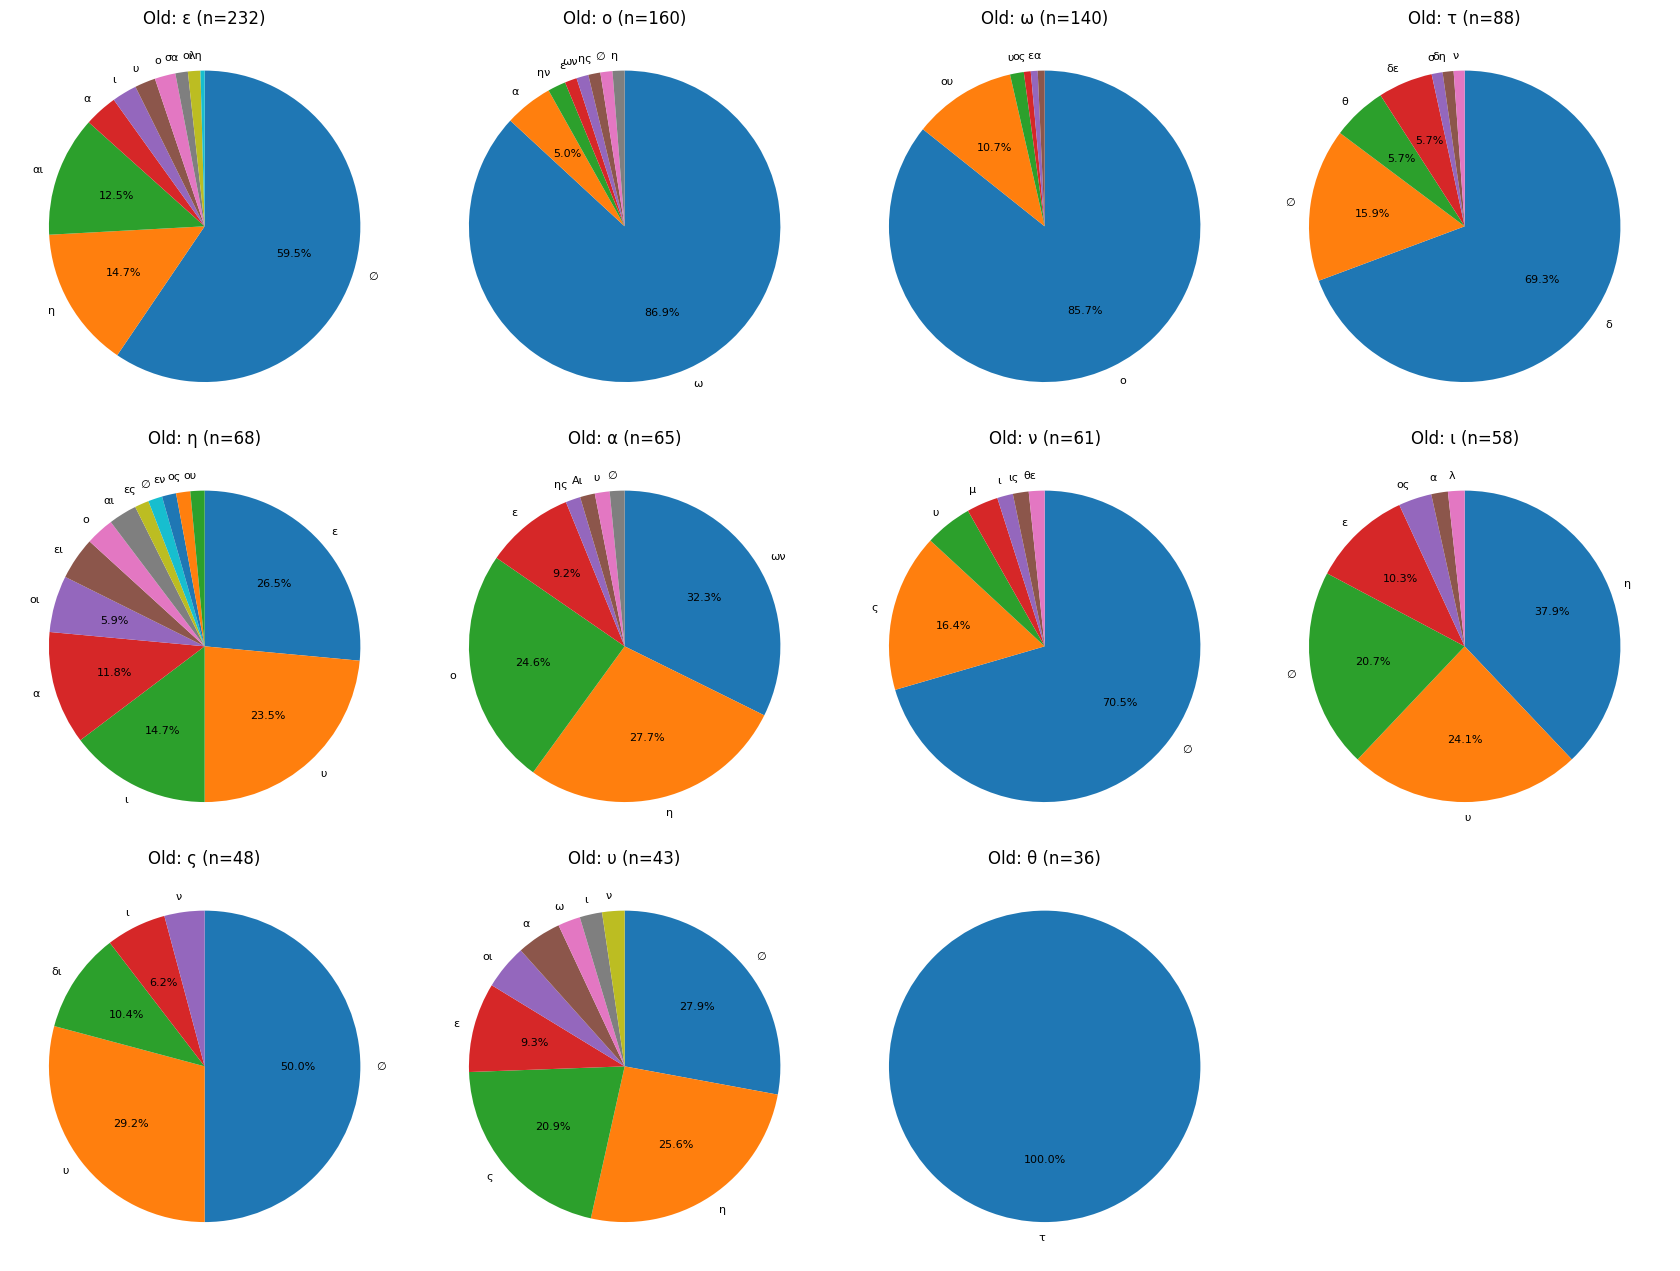

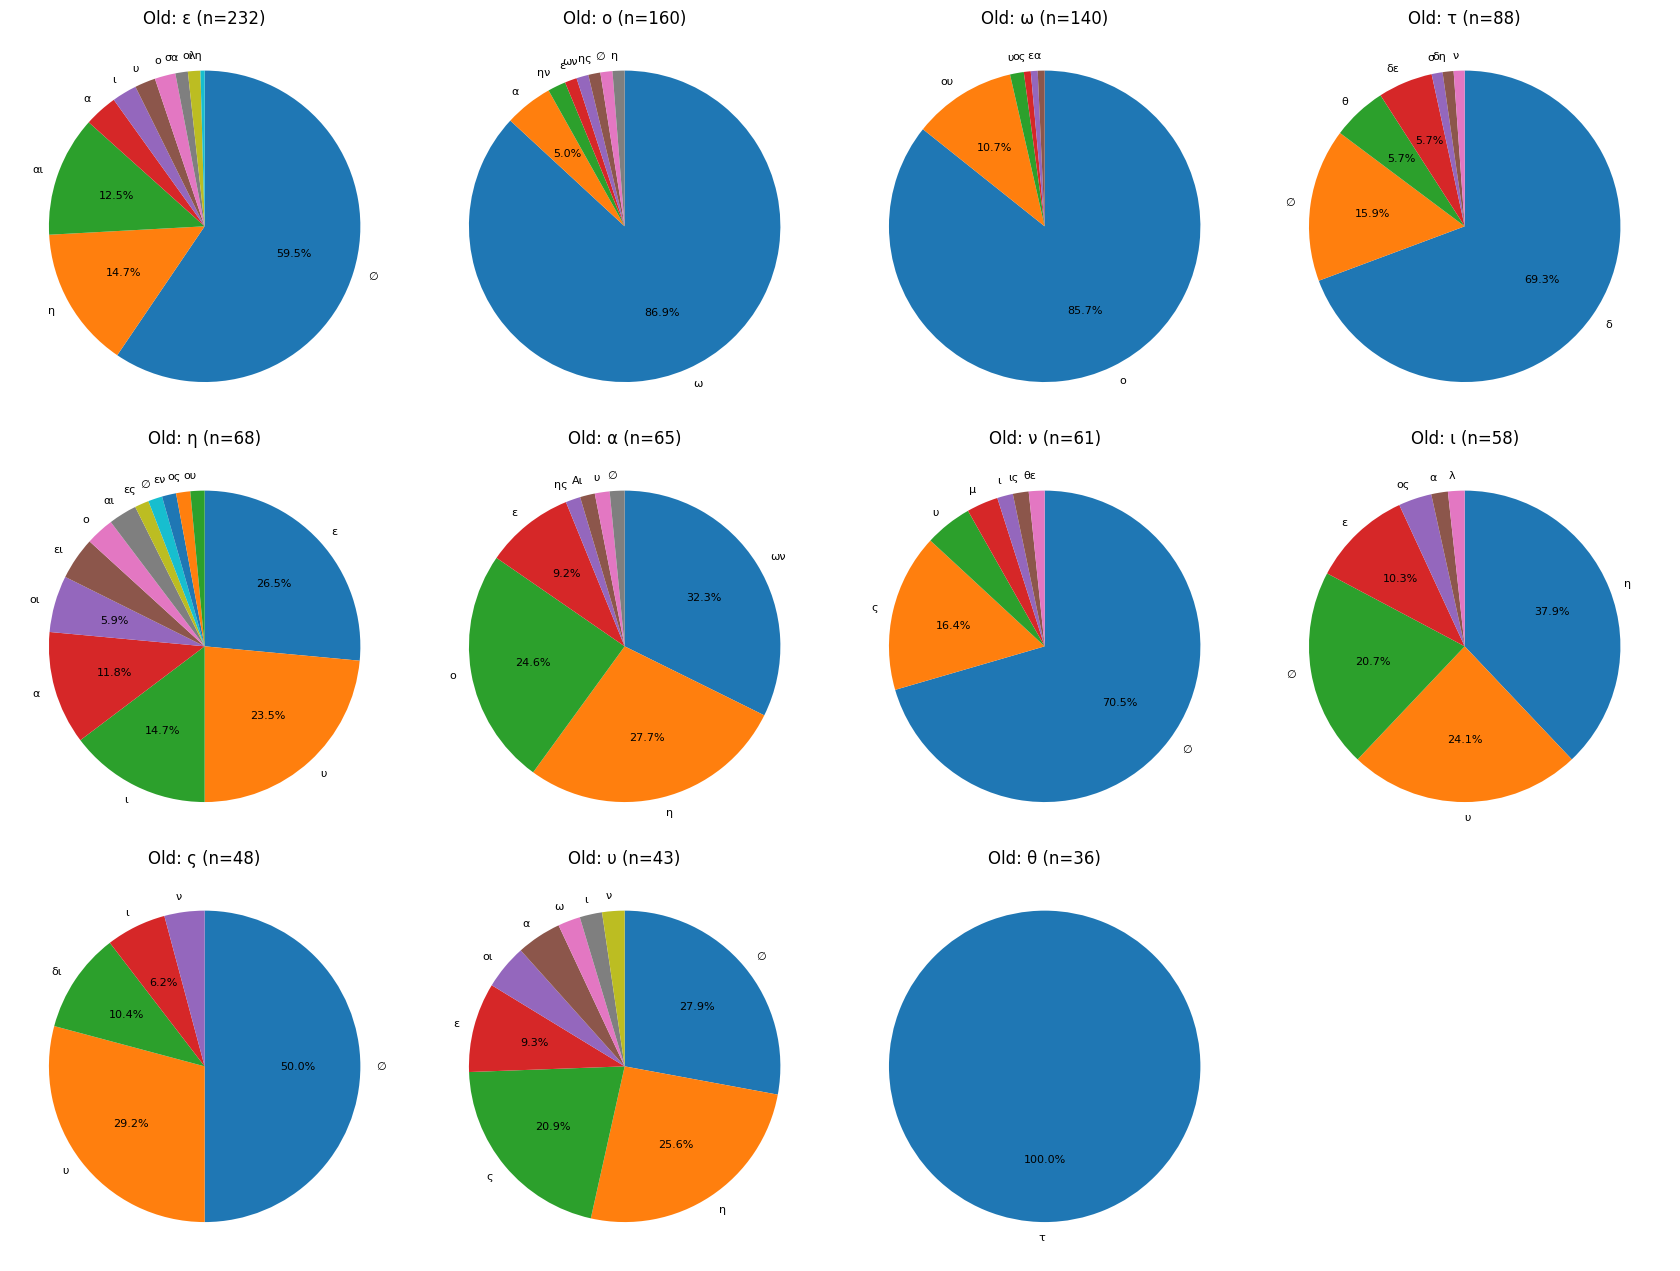

In [ ]:
#@title Visualisation du test 1

import math
import re
from typing import List

import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots


# Greek + Greek Extended blocks (covers most polytonic precomposed letters too)
_GREEK_CHAR_RE = re.compile(r"^[\u0370-\u03FF\u1F00-\u1FFF]$")

def is_single_greek_grapheme(x: object) -> bool:
    s = "" if x is None else str(x)
    return len(s) == 1 and bool(_GREEK_CHAR_RE.match(s))


# Keep only "grapheme-level" edits: single-character Old graphemes (Greek), non-empty
grapheme_edits = sound_change_df.loc[
    sound_change_df["Old"].map(is_single_greek_grapheme),
    ["Old", "New"],
].copy()

# Count how many times each Classical Greek grapheme (Old) was modified
old_counts = grapheme_edits["Old"].value_counts()

# Graphemes modified > 30 times
modified_gt_30 = old_counts[old_counts > 30]
graphemes_gt_30: List[str] = modified_gt_30.index.tolist()

print("Graphemes modified more than 30 times:")
print(modified_gt_30)

# Pie charts: for each Old grapheme, show distribution of its New forms
# (include insertions to multiple chars; deletions shown as '∅')
def plot_new_forms_pies(edits_df: pd.DataFrame, graphemes: List[str]):
    if not graphemes:
        raise ValueError("No graphemes found with count > 30 (nothing to plot).")

    n = len(graphemes)
    ncols = min(4, n)
    nrows = math.ceil(n / ncols)

    fig, axes = subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(4.2 * ncols, 4.2 * nrows),
        constrained_layout=True,
    )

    # Robust flatten (matplotlib returns Axes or ndarray depending on shape)
    if isinstance(axes, np.ndarray):
        ax_list = axes.ravel().tolist()
    else:
        ax_list = [axes]

    for i, old_g in enumerate(graphemes):
        ax = ax_list[i]
        sub = edits_df[edits_df["Old"] == old_g].copy()

        # Label deletions (empty new string)
        sub["New"] = sub["New"].fillna("").replace({"": "∅"})

        new_counts = sub["New"].value_counts()

        ax.pie(
            new_counts.values,
            labels=new_counts.index.tolist(),
            autopct=lambda p: f"{p:.1f}%" if p >= 5 else "",  # reduce label clutter
            startangle=90,
            counterclock=False,
            textprops={"fontsize": 8},
        )
        ax.set_title(f"Old: {old_g} (n={len(sub)})")

    # Turn off any unused subplot axes
    for j in range(n, len(ax_list)):
        ax_list[j].axis("off")

    return fig


fig = plot_new_forms_pies(grapheme_edits, graphemes_gt_30)
fig

Qui dit échantillon plus grand dit résultats plus solides.
Or, il semble que les données de la colonne 'Text Irregularities' du fichier originel soient tout à fait pertinentes.

In [ ]:
import pandas as pd
import difflib
import ast

df = pd.read_csv('/content/papyrus_corpus.csv')

results = []
for cell in df['Text Irregularities'].dropna():
    try:
        items = ast.literal_eval(str(cell))
    except (ValueError, SyntaxError):
        continue

    if not isinstance(items, list):
        continue

    for item in items:
        if isinstance(item, str) and ': read ' in item:
            A, B = item.split(': read ', 1)
            results.extend(delta(A.strip(), B.strip()))

# Creation du DataFrame
sound_change_df = pd.DataFrame(results, columns=['Old', 'New'])

Cette fonction basée sur la [Distance de Levenshtein](https://fr.wikipedia.org/wiki/Distance_de_Levenshtein) (nombre minimal d'opérations pour passer d'un mot à l'autre) semble mieux cibler les erreurs scribales.

Graphemes modified more than 30 times:
Old
ε    232
ο    160
ω    140
τ     88
η     68
α     65
ν     61
ι     58
ς     48
υ     43
θ     36
Name: count, dtype: int64


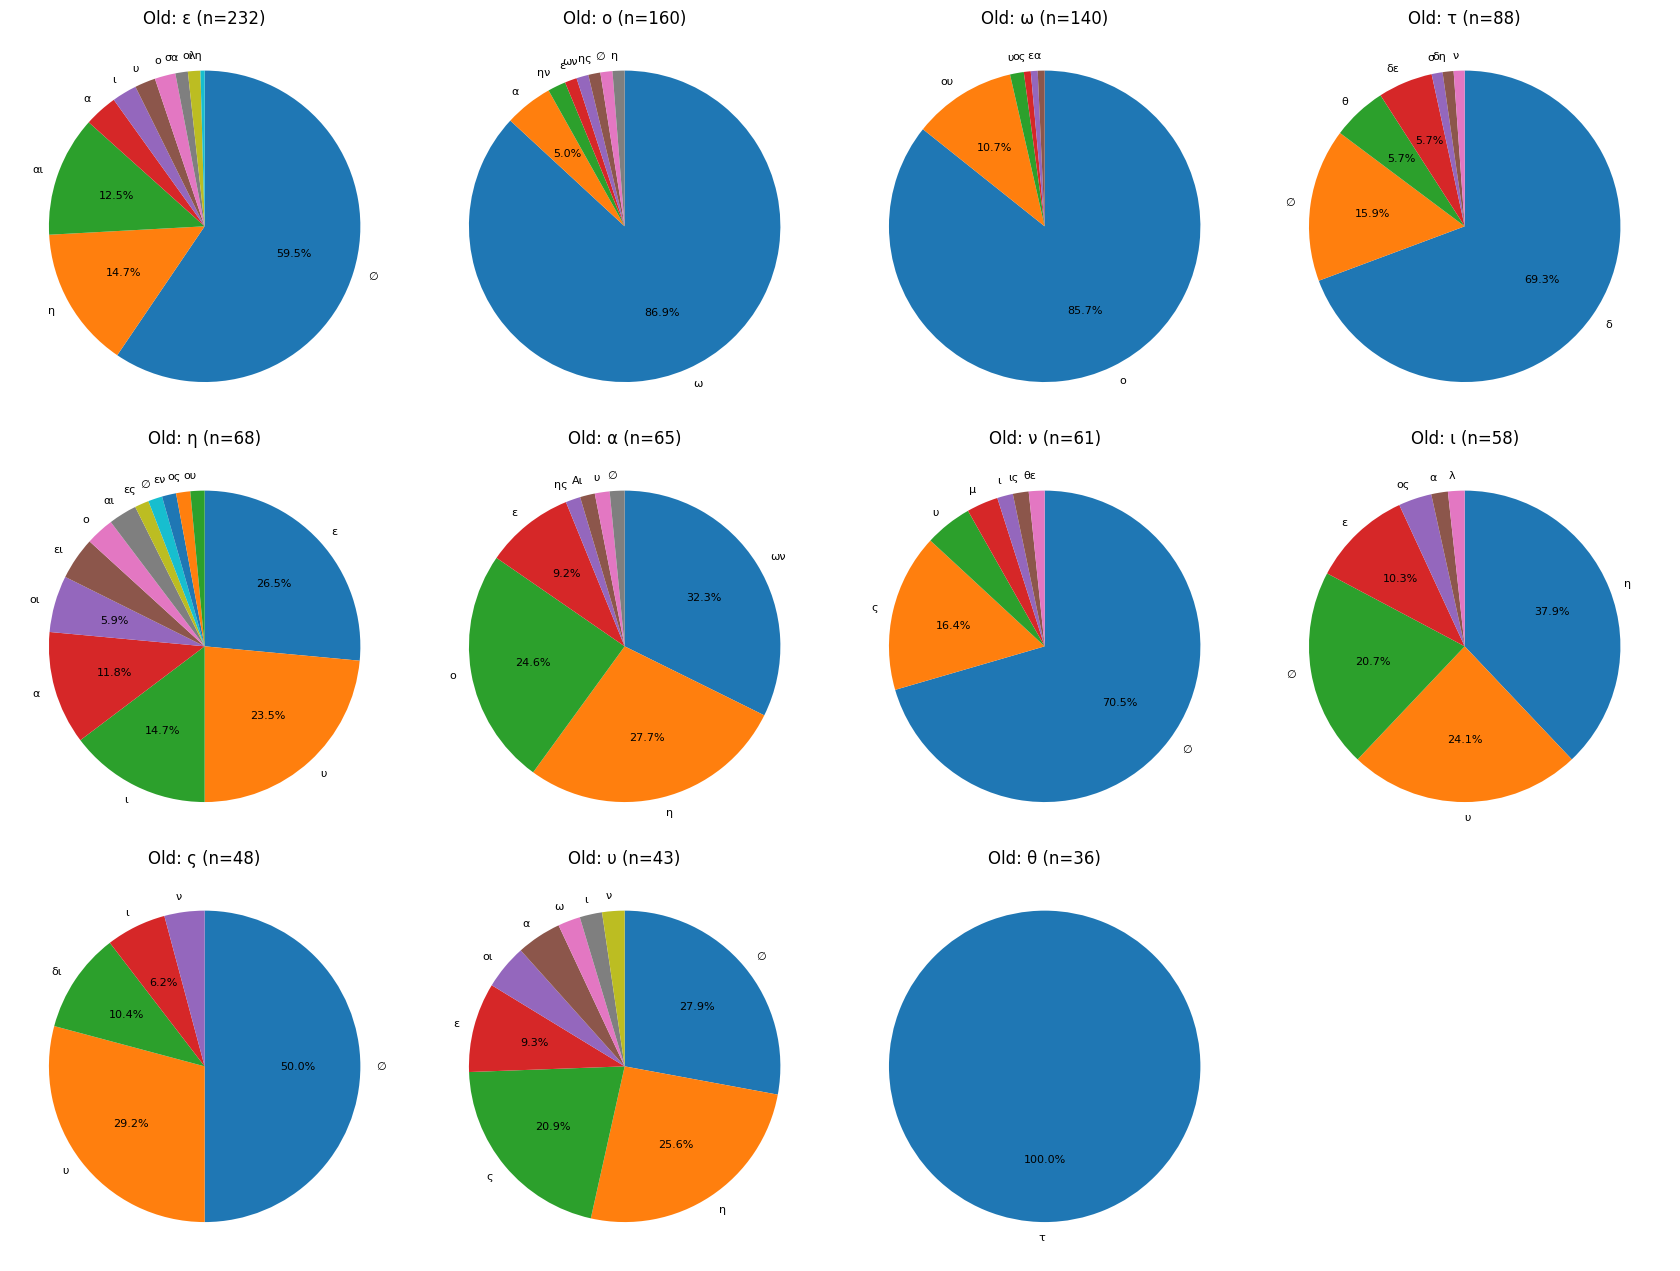

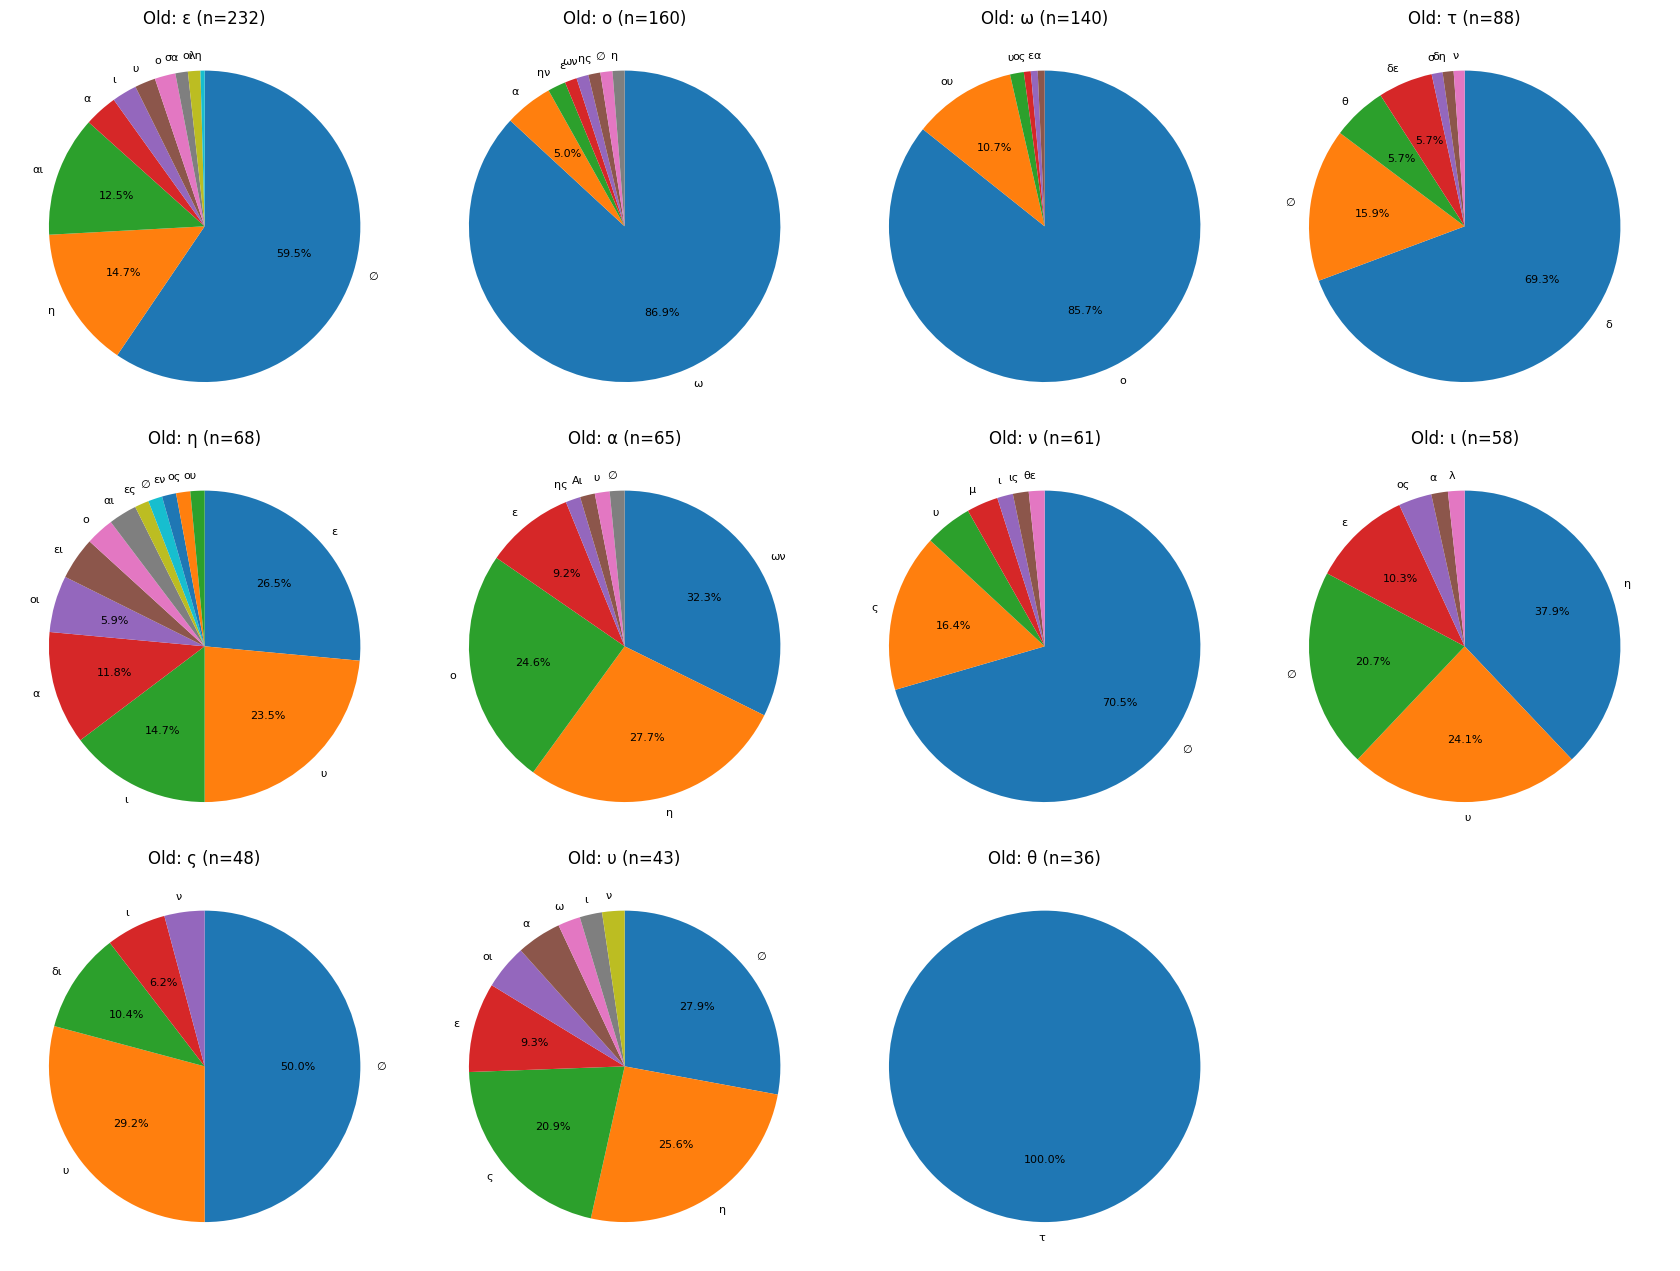

In [ ]:
#@title Visualisation du test sur corpus brut

import math
import re
from typing import List

import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots


# Greek + Greek Extended blocks (covers most polytonic precomposed letters too)
_GREEK_CHAR_RE = re.compile(r"^[\u0370-\u03FF\u1F00-\u1FFF]$")

def is_single_greek_grapheme(x: object) -> bool:
    s = "" if x is None else str(x)
    return len(s) == 1 and bool(_GREEK_CHAR_RE.match(s))


# Keep only "grapheme-level" edits: single-character Old graphemes (Greek), non-empty
grapheme_edits = sound_change_df.loc[
    sound_change_df["Old"].map(is_single_greek_grapheme),
    ["Old", "New"],
].copy()

# Count how many times each Classical Greek grapheme (Old) was modified
old_counts = grapheme_edits["Old"].value_counts()

# Graphemes modified > 30 times
modified_gt_30 = old_counts[old_counts > 30]
graphemes_gt_30: List[str] = modified_gt_30.index.tolist()

print("Graphemes modified more than 30 times:")
print(modified_gt_30)

# Pie charts: for each Old grapheme, show distribution of its New forms
# (include insertions to multiple chars; deletions shown as '∅')
def plot_new_forms_pies(edits_df: pd.DataFrame, graphemes: List[str]):
    if not graphemes:
        raise ValueError("No graphemes found with count > 30 (nothing to plot).")

    n = len(graphemes)
    ncols = min(4, n)
    nrows = math.ceil(n / ncols)

    fig, axes = subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(4.2 * ncols, 4.2 * nrows),
        constrained_layout=True,
    )

    # Robust flatten (matplotlib returns Axes or ndarray depending on shape)
    if isinstance(axes, np.ndarray):
        ax_list = axes.ravel().tolist()
    else:
        ax_list = [axes]

    for i, old_g in enumerate(graphemes):
        ax = ax_list[i]
        sub = edits_df[edits_df["Old"] == old_g].copy()

        # Label deletions (empty new string)
        sub["New"] = sub["New"].fillna("").replace({"": "∅"})

        new_counts = sub["New"].value_counts()

        ax.pie(
            new_counts.values,
            labels=new_counts.index.tolist(),
            autopct=lambda p: f"{p:.1f}%" if p >= 5 else "",  # reduce label clutter
            startangle=90,
            counterclock=False,
            textprops={"fontsize": 8},
        )
        ax.set_title(f"Old: {old_g} (n={len(sub)})")

    # Turn off any unused subplot axes
    for j in range(n, len(ax_list)):
        ax_list[j].axis("off")

    return fig


fig = plot_new_forms_pies(grapheme_edits, graphemes_gt_30)
fig

Représentez le graphe de conversion de sons (chaque noeud représente un son, le poids d'une arrete le nombre de changements constatés dans le corpus) (utilisez par exemple networkx ou pyvis)

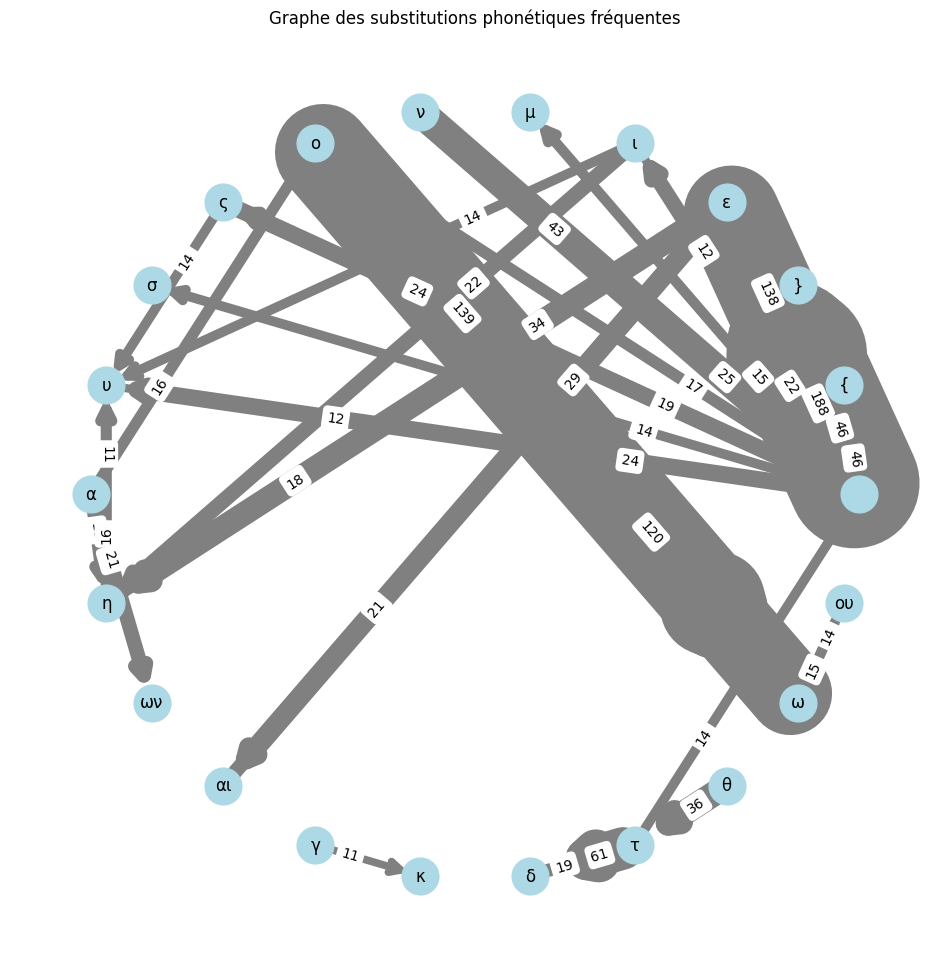

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

# Filtrer pour garder les changements significatifs (bruit vs tendance)
min_occurrence = 10
filtered_changes = sound_change_df.groupby(['Old', 'New']).size().reset_index(name='weight')
filtered_changes = filtered_changes[filtered_changes['weight'] > min_occurrence]

for _, row in filtered_changes.iterrows():
    G.add_edge(row['Old'], row['New'], weight=row['weight'])

plt.figure(figsize=(12, 12))
# Layout circulaire idéal pour voir les échanges de voyelles
pos = nx.circular_layout(G)

# Dessin des noeuds
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')

# Dessin des arêtes avec épaisseur proportionnelle au poids
edges = G.edges()
weights = [G[u][v]['weight'] * 0.5 for u, v in edges]
nx.draw_networkx_edges(G, pos, width=weights, arrowstyle='->', arrowsize=20, edge_color='gray')

# Labels
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

# Labels des arêtes (poids)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.3)

plt.title("Graphe des substitutions phonétiques fréquentes")
plt.axis('off')
plt.show()